In [23]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandasql import sqldf
import matplotlib
import datetime
matplotlib.rcParams.update({'font.size': 22})
plt.rcParams['font.family']=['STFangsong']
starttime = datetime.datetime.now()
###########
#改變時間格式
###########
def Time_processing(d, t, ms):
    d = d.replace('/', '-')
    ds = d.split('-')
    d = ds[0] + '-' + ds[1].zfill(2) + '-' + ds[2].zfill(2)
    ts = t.split(':')
    t = ts[0].zfill(2) + ':' + ts[1].zfill(2) + ':' + ts[2].zfill(2)
    return d + ' ' + t + '.' + str(ms).zfill(3)
###########
#獨進所有的plc.csv檔，並將其concate在一起成為一個dataframe 傳回
###########
def Read_plc(plc_dir):
    csv_files = os.listdir(plc_dir)
    df = pd.DataFrame()
    df_list = []
    for c in csv_files:
        if c[-4:] == '.csv': 
            df_ = pd.read_csv(plc_dir + c, encoding='big5')
            df_['file'] = c
            df_list.append(df_)
    df = pd.concat(df_list)
    df['time'] = np.vectorize(Time_processing)(df['日期'],df['時間'],df['毫秒'])
    df.drop(['日期','時間','毫秒'],axis=1, inplace=True)
    df['實際進給'] = pd.to_numeric(df['實際進給'], errors='coerce').fillna(0)
    df['實際轉速'] = pd.to_numeric(df['實際轉速'], errors='coerce').fillna(0)
    df['設定進給'] = pd.to_numeric(df['設定進給'], errors='coerce').fillna(0)
    df['設定轉速'] = pd.to_numeric(df['設定轉速'], errors='coerce').fillna(0)
    df['Z軸機械座標'] = df.apply(lambda x: round(x['Z軸機械座標'],4), axis=1)
    print('Read_plc() finish!!!')
    print('time cost:', datetime.datetime.now()-starttime)
    return df


def Time_diff(x):
    t1 = datetime.datetime.strptime(x['time_begin'], '%Y-%m-%d %H:%M:%S.%f').timestamp() * 1000
    t2 = datetime.datetime.strptime(x['time_end'], '%Y-%m-%d %H:%M:%S.%f').timestamp() * 1000
    return t2 - t1
    
def Preprocess_df(plc_dir):
    plc_df = Read_plc(plc_dir)
    sql =("SELECT min(time) AS time_begin, max(time) AS time_end,"
                     "單節, 主軸負載, X軸機械座標, Y軸機械座標, Z軸機械座標,"
                     "實際進給, 實際轉速, 設定進給, 設定轉速, file, 進給率 "
                     "FROM plc_df "
                     "WHERE 單節 IS NOT NULL and 實際進給>0 and 實際轉速>0 "
                     " GROUP BY 單節, 主軸負載, X軸機械座標, Y軸機械座標, Z軸機械座標, "
                     "         實際進給, 實際轉速, file "
                     "ORDER BY time_begin, time_end")
    #設定進給==10000 and 設定轉速==2000 and 進給率==100 
    data = sqldf(sql, locals())
    data.reset_index(level=0, inplace=True)
    data['index0'] = data.index
    data['time_diff'] = data.apply(Time_diff,axis=1)

    return data


def Create_sgroup(data):
    zs = data['Z軸機械座標'].values
    sg = np.zeros(len(zs))#small group
    sg[0] = 1
    z_app = [zs[0]] # non-redundant z appears as time passes by
    z_ctr = [] # non-redundant z counter as time passes by
    c = 1
   
    for i in range(1, len(zs)):
        if zs[i] == zs[i-1]: 
            sg[i] = sg[i-1]
            c += 1
        else: 
            z_ctr.append(c)
            sg[i] = sg[i-1] + 1
            z_app.append(zs[i])
            c = 1
    z_ctr.append(c)
    return z_app, z_ctr

def Add_path(df):
    zs = df['z'].values
    c = 1
    path = []
    z_curr = zs[0]
    for z in zs:
        if z <= z_curr: 
            z_curr = z
            path.append(c)
        else:
            c += 1
            z_curr = z
            path.append(c)
    df['path'] = path
    return df

def Add_layer(df):
    dfs = []
    for l in df.path.unique():
        df1 = df[df.path==l]
        zs = df1['z'].values
        cs = df1['count'].values
        layer = np.zeros(len(df1))
        c = 1
        for curr in range(0, len(df1)-1):
            if layer[curr] == 0:
                layer[curr] = 1
            curr_z = zs[curr]
            curr_c = cs[curr]
            comp_z = zs[curr+1]
            comp_c = cs[curr+1]
            if round(comp_z-curr_z,3) == 0:
                layer[curr+1] = layer[curr]
                c += 1
            elif (round(comp_z-curr_z,3) == -0.6):# and (np.abs(comp_c-curr_c)<13) :
                layer[curr+1] = layer[curr] + 1
                c += 1
            elif comp_z-curr_z < -1.2:
                if c > 2:
                    break
                else:
                    layer[curr] = 0
                    curr += 1
                    
                    
                
        df1['layer'] = layer
        dfs.append(df1)
    df = pd.concat(dfs)
    return df

def Back_ori(aft_df, cha_df):
    cha_z = cha_df['z'].values
    cha_c = cha_df['count'].values
    cha_p = cha_df['path'].values
    cha_l = cha_df['layer'].values
    aft_z = []
    aft_p = []
    aft_l = []
    
    for i in range(len(cha_c)):
        aft_z += [cha_z[i]] * cha_c[i]
        aft_p += [cha_p[i]] * cha_c[i]
        aft_l += [cha_l[i]] * cha_c[i]
    aft_df['z_'] = aft_z
    aft_df['path'] = aft_p
    aft_df['layer'] = aft_l
    return aft_df

def Seg_df(data):
    print(data.columns)
    z_app, z_ctr = Create_sgroup(data)
    z_info = pd.DataFrame({'z':z_app, 'count':z_ctr})
    z_info['idx'] = z_info.index.values
    z1 = z_info[z_info['count']>10]

    z_idx = z1.index.values
    cols = ['idx', 'z', 'count']
    z1 = z1[cols]
    z2 = Add_path(z1)
    z3 = Add_layer(z2)
    cols = ['idx', 'z', 'count', 'path', 'layer']
    z4 = z3[cols]
    z4 = Modi_layer(z4)
    z5 = z_info.merge(z4, left_on='idx', right_on='idx', how='outer')
    cols = ['idx', 'z_x', 'count_x', 'path', 'layer']
    z6 = z5[cols]
    z6.columns = ['idx', 'z', 'count', 'path', 'layer']
    z7 = Back_ori(data, z6) 
    cols = ['index', 'time_begin', 'time_end', '單節', '主軸負載', 
           'Z軸機械座標', '實際進給', '實際轉速', '設定進給', '設定轉速', 'index0', 'z_',
           'path', 'layer', '進給率']
    #print(z7.columns)
    z8 = z7[cols]
    endtime = datetime.datetime.now()
    print('Seg_df() finish!!! time cost:', endtime-starttime)
    
    return z8

def Get_draws(z8):
    draws = []
    path = z8.path.nunique()
    
    for p in range(1,path+1):
        z9 = z8[z8.path==p]
        d = []
        layer_sz = z9.layer.nunique()
        if z9.layer.nunique()>2:
            d.append((p, 2))
            d.append((p, int(layer_sz/2)))
            d.append((p, layer_sz-1))
            draws.append(d)
    return draws

def Get_part(z8, p, l):
    sql = "SELECT * FROM z8 WHERE path==" + str(p)
    sql += " and layer==" + str(l) 
    sql += " ORDER BY index0"
    z9 = sqldf(sql, locals())
    return z9

def Draw_basic(z8, data):
    plt.figure(figsize=(15,9))
    plt.plot(data['X軸機械座標'],data['Y軸機械座標'], c='y')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('XY加工路徑')
    plt.show()

    plt.figure(figsize=(15,9))
    plt.subplot(711)
    plt.plot(z8['index0'],z8['Z軸機械座標'], c='y')
    plt.ylabel('Z')


    plt.subplot(712)
    plt.plot(z8['index0'],z8['主軸負載'], c='y')
    plt.ylabel('loading')

    plt.subplot(713)
    colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
    
    for i in range(1,z8.path.nunique()+1):
        p = i
        if p >= 1:
            plt.plot(z8[z8['path']==p]['index0'],z8[z8['path']==p]['主軸負載'], c=colors[i-1], label=str(p))
    plt.ylabel('loading')
    
    plt.subplot(714)
    plt.plot(z8['index0'],z8['實際轉速'], c='y')
    plt.ylabel('實際轉速')
    
    plt.subplot(715)
    plt.plot(z8['index0'],z8['實際進給'], c='y')
    plt.ylabel('實際進給')

    plt.subplot(716)
    plt.plot(z8['index0'],z8['設定轉速'], c='y')
    plt.ylabel('設定轉速')

    
    plt.legend(loc='best') 
    plt.xlabel('time')
    plt.show()
    
    
    
    
    
def Draw_diff(z8, draws):
    for dr in draws:
        plt.figure(figsize=(15,9))
        sub = [311, 312, 313]
        clist = ['y', 'g', 'b']
        for i,d in enumerate(dr):
            p, l = d[0], d[1]
            part_z = Get_part(z8, p, l)
            plt.subplot(sub[i])
            leg = 'path:'+str(p)+', layer:'+str(l)
            print(leg, len(part_z))
            plt.plot(part_z['index0'],part_z['主軸負載'], c=clist[i], label=leg)
            plt.legend(loc='best') 
            plt.ylabel('loading')
        plt.xlabel('time')
        plt.show()

#將同一path中，中間有斷掉或是shift的seq再接起來，例如前五個都是差-0.6，後五個也是差-0.6，但是中間shift掉0.2，此function可以把這兩個
#seq再接起來
def Modi_layer(z4):
    #先找出同一path中，相鄰的row的layer difference，這是為了要知道每個seq 的長度
    idx_diff = {}
    for p in z4['path'].unique():
        p_df = z4[z4['path']==p]
        ls = p_df['layer'].values
        idx = p_df['idx'].values
        idx_diff[idx[0]] = 0
        for i in range(1, len(ls)):
            idx_diff[idx[i]] = ls[i] - ls[i-1]
    
    diff = []
    for i in z4.idx.values:
        diff.append(idx_diff[i])
    z4['diff_layer'] = diff
    m_ht = {}
    
    #若是同一path中，有至少兩條seq，則找出第二條seq的起始的idx，再加上第一條seq len，重新更改其layer
    for p in z4['path'].unique():
        lens = []
        p_df = z4[z4['path']==p]
        ds = p_df.diff_layer.values
        for d in ds:
            if d < -1:
                lens.append(np.abs(d))
        
            
        if len(lens) > 1:
            l_df = p_df[p_df['layer']==2]
            
            #找出第二條seq的起始的idx，
            idx_arr = []
            curr_z = -99999
            for i in range(len(l_df)):
                idx = l_df.iloc[i].idx
                z = l_df.iloc[i].z
                if z != curr_z:
                    idx_arr.append(idx)
                    curr_z = z
            
            
            #將其改成(起始的idx, 要增加的長度）
            m_arr = []
            for i in range(len(idx_arr)-1):
                len_sum = 0
                for j in range(i+1):
                    len_sum += lens[i]
                m_arr.append((idx_arr[i+1], len_sum))
            
            #在m_arr改layer, 若是該row的layer_diff>=0就可以改，表示是屬同一seq
            #將他有改的部分存在m_ht中，記錄其[idx]=new_layer
            for m in m_arr:
                m_i = m[0]
                m_len = m[1]
                m_tag = 0
                for i in range(len(p_df)):
                    if p_df.iloc[i].idx >= m_i and p_df.iloc[i].diff_layer >= 0:
                        m_ht[p_df.iloc[i].idx] = p_df.iloc[i].layer + m_len
                        m_tag = 1
                    else:
                        if m_tag == 0:
                            continue
                        else:
                            break
    
    #最後根據m_ht中的idx, new_layer來改z4中的layer
    idx_arr = z4.idx.values
    layer_arr = z4.layer.values
    for i in range(len(idx_arr)):
        idx = idx_arr[i]
        if idx in m_ht:
            layer_arr[i] = m_ht[idx]        
    return z4


In [24]:
def Deal_plc(plc_dir):
    data = Preprocess_df(plc_dir)
    z8 = Seg_df(data)

    Draw_basic(z8, data)
    draws = Get_draws(z8)
    #Draw_diff(z8, draws)
    return z8

In [25]:
import pywt
from sklearn.mixture import GMM

def Calc_dwt_base(z15, ratio=0.2):
    base_df = z15[:int(len(z15)*ratio)]
    rest_df = z15[int(len(z15)*ratio):]
    #cA, cD = pywt.dwt(list(base_df['主軸負載'].values), 'db2')
    coeff = pywt.wavedec(list(base_df['主軸負載'].values),'db2',mode='sym', level=2)   # 按 level 层分解，使用pywt包进行计算， cAn是尺度系数 cDn为小波系数
    cA, cD = coeff[0], coeff[1]
    g_base_df = pd.DataFrame({'cA':cA, 'cD':cD})
    
    n_components = np.arange(1, 21)
    models = [GMM(n, covariance_type='full', random_state=0).fit(g_base_df) for n in n_components]
    aics = [m.aic(g_base_df) for m in models]
    #print(aics)
    n_c = n_components[aics.index(min(aics))]
    #print(n_c)
    gmm = GMM(n_components=n_c).fit(g_base_df)
    base_score = gmm.score_samples(g_base_df)[0]
    t_df = pd.DataFrame({'base_score':base_score})
    rooling_base = t_df.rolling(100).mean()
    
    rest_df = rest_df[rest_df.path>=1]
    rest_scores = []
    for p in rest_df.path.unique():
        t_df = rest_df[rest_df['path']==p]
        for l in t_df.layer.unique():
            #print(p,l)
            t_df_layer = t_df[t_df['layer']==l]
            cA1, cD1 = pywt.dwt(list(t_df_layer['主軸負載'].values), 'db2')
            #print(len(cA1), len(cD1))
            g_rest_df = pd.DataFrame({'cA':cA1, 'cD':cD1})
            rest_score = gmm.score_samples(g_rest_df)[0]
            #print('rest_score', rest_score)
            rest_scores += list(rest_score)
            
            #rest_scores.append(rest_score)
    #print(base_score)
    #print(rest_scores)
    plt.figure(figsize=(15,9))
    #y1 = list(base_score)
    y1 = rooling_base.base_score.values
    plt.scatter(range(len(y1)), y1,c='r', label='baseline data (first 1/10)')
    t_df = pd.DataFrame({'rest_score':rest_scores})
    rooling_rest = t_df.rolling(100).mean()
    
    #y2 = list(rest_scores)
    y2 = rooling_rest.rest_score.values
    plt.scatter(range(len(y1), len(y1)+len(y2)), y2,c='b', label='left data')
    plt.xlabel('time')
    plt.ylabel('score')
    plt.show()


In [26]:
def Calc_stat(z8):
    paths = []
    layers = []
    counts = []
    means = []
    stds = []
    rms2 = []
    maxs = []
    mins = []
    p25 = []
    p75 = []
    hist = []
    h0 = []
    h5 = []
    h10 = []
    h15 = []
    h20 = []
    h25 = []
    h30 = []
    h35 = []
    h40 = []
    
    for p in z8.path.unique():
        z9 = z8[z8.path==p]
        d = []
        
        if z9.layer.nunique() <= 2:
            continue
        for l in z9.layer.unique():
            if l > 1:
                z10 = z9[z9.layer==l]
                loads = z10['主軸負載'].values
                if len(loads)==0:
                    continue
                #print(p, l, len(z10), round(np.mean(loads),1), round(np.std(loads),1))
                paths.append(p)
                layers.append(l)
                counts.append(len(z10))
                means.append(round(np.mean(loads),1))
                stds.append(round(np.std(loads),1))
                rms2.append(np.sqrt(np.sum(np.power(loads,2)/len(loads))))
                maxs.append(np.max(loads))
                mins.append(np.min(loads))
                p25.append(np.percentile(loads, 25))
                p75.append(np.percentile(loads, 75))
                his = np.histogram(loads, bins=range(0,45,5))[0]
                #print(his)
                h0.append(his[0])
                h5.append(his[1])
                h10.append(his[2])
                h15.append(his[3])
                h20.append(his[4])
                h25.append(his[5])
                h30.append(his[6])
                h35.append(his[7])
                #hist+=list(np.histogram(loads, bins=range(0,45,5))[0])
            
                
    return pd.DataFrame({'path':paths, 'layer':layers, 'count':counts, 'mean':means, 'std': stds, 'rms2':rms2, 'max':maxs, 'min':mins, 'p25':p25, 'p75':p75, 'h0':h0,'h5':h5,'h10':h10,'h15':h15,'h20':h20,'h25':h25,'h30':h30,'h35':h35})



In [27]:
def Dras_stat(z15):
    z15.to_csv('stat.csv')
    stat_df = Calc_stat(z15)
    print(stat_df.describe())
    colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
    plt.figure(figsize=(15,9))
    counter = 0
    for p in stat_df.path.unique():
        t_df = stat_df[stat_df.path==p]
        c = colors[counter]
        plt.plot(t_df.index, t_df['mean'].values, c=c, label=str(p))
        counter += 1
    plt.xlabel('#data points')
    plt.ylabel('loading')
    plt.legend(loc='best') 
    plt.title('mean_loading in different paths')
    plt.show()

    plt.figure(figsize=(15,9))
    counter = 0
    
    for p in stat_df.path.unique():
        t_df = stat_df[stat_df.path==p]
        c = colors[counter]

        plt.plot(t_df.index, t_df['std'].values, c=c, label=str(p))
        counter += 1
    plt.xlabel('#data points')
    plt.ylabel('loading')
    plt.legend(loc='best') 
    plt.title('std_loading in different paths')
    plt.show()

    plt.figure(figsize=(15,9))
    counter = 0
    
    for p in stat_df.path.unique():
        t_df = stat_df[stat_df.path==p]
        c = colors[counter]

        plt.plot(t_df.index, t_df['rms2'].values, c=c, label=str(p))
        counter += 1
    plt.xlabel('#data points')
    plt.ylabel('loading')
    plt.legend(loc='best') 
    plt.title('rms_loading in different paths')
    plt.show()
    
    plt.figure(figsize=(15,9))
    counter = 0
    
    for p in stat_df.path.unique():
        t_df = stat_df[stat_df.path==p]
        c = colors[counter]

        plt.plot(t_df.index, t_df['max'].values, c=c, label=str(p))
        counter += 1
    plt.xlabel('#data points')
    plt.ylabel('loading')
    plt.legend(loc='best') 
    plt.title('max_loading in different paths')
    plt.show()
    return stat_df

In [75]:
from sklearn.mixture import GMM
from scipy.stats import pearsonr
def Draw_GMM(stat_df_15):
    len(stat_df_15)
    tmp_df = stat_df_15[['std']]
    #tmp_df = stat_df_15[['h0', 'h5', 'h10', 'h15', 'h20', 'h25', 'h30', 'h35','count', 'mean', 'std', 'rms2','max', 'min']]
    
    #tmp_df = stat_df_15[['count', 'mean', 'std', 'rms2','max']]
    tmp_df = np.cumsum(tmp_df)
    N = int(len(tmp_df)/10)
    print('N', N)
    base_df = tmp_df[:N]
    rest_df = tmp_df[N:]
    n_components = np.arange(1, N)
    models = [GMM(n, covariance_type='full', random_state=0).fit(base_df) for n in n_components]
    aics = [m.aic(base_df) for m in models]
    print(aics)
    n_c = n_components[aics.index(min(aics))]
    print(n_c)
    gmm = GMM(n_components=n_c).fit(base_df)
    base_score = gmm.score_samples(base_df)[0]
    rest_score = gmm.score_samples(rest_df)[0]
    plt.figure(figsize=(15,9))
    plt.subplot(3,1,1)
    y1 = list(base_score)
    plt.scatter(range(len(y1)), y1,c='r', label='baseline data (first 1/10)')
    y2 = list(rest_score)
    plt.scatter(range(len(y1), len(y1)+len(y2)), y2,c='b', label='left data')
    plt.xlabel('layer index')
    plt.ylabel('score')
    plt.show()

def normalize(raw):
    norm = [float(i)/sum(raw) for i in raw]
    return norm


def Draw_Corr(stat_df_15, SATART_N=2):
    len(stat_df_15)
    #tmp_df = stat_df_15[['count', 'mean', 'std', 'rms2', 'max', 'min', 'p25', 'p75']]
    tmp_df = stat_df_15[['h0', 'h5', 'h10', 'h15', 'h20', 'h25', 'h30', 'h35']]#,'count', 'mean', 'std']]
    #print(tmp_df.head())
    tmp_df = tmp_df[SATART_N:]
    tmp_df = np.cumsum(tmp_df)
    N = int(len(tmp_df)/10)
    base_score = []
    rest_score = []
    for i in range(N):
        t_list = []
        x = tmp_df.iloc[i]
        for j in range(N):
            if i != j:
                y = tmp_df.iloc[j]
                #c, p = pearsonr(x,y)
                #t_list.append(c)
                out = np.dot(normalize(x),normalize(y))
                #c, p = pearsonr(x,y)
                t_list.append(out)

                #print(i,j,c,p)
        base_score.append(np.mean(t_list))
    
    for i in range(N,len(tmp_df)-1):
        t_list = []
        x = tmp_df.iloc[i]
        
        for j in range(N):
            #print(i,j)
            y = tmp_df.iloc[j]
            
            out = np.dot(normalize(x),normalize(y))
            #c, p = pearsonr(x,y)
            t_list.append(out)
            #print(i,j,c,p)
        rest_score.append(np.mean(t_list))
    plt.figure(figsize=(15,9))
    plt.subplot(3,1,1)
    y1 = list(base_score)
    plt.scatter(range(len(y1)), y1,c='r', label='baseline data (first 1/10)')
    y2 = list(rest_score)
    plt.scatter(range(len(y1), len(y1)+len(y2)), y2,c='b', label='left data')
    plt.xlabel('grouped data index')
    plt.ylabel('similarity(dot-product)')
    plt.legend(loc='best')
    plt.show()



def Draw_Corr_End_To_First(stat_df_15,START_N=2):
    len(stat_df_15)
    #tmp_df = stat_df_15[['count', 'mean', 'std', 'rms2', 'max', 'min', 'p25', 'p75']]
    tmp_df = stat_df_15[['h0', 'h5', 'h10', 'h15', 'h20', 'h25', 'h30', 'h35']]#,'count', 'mean', 'std']]
    N = int(len(tmp_df)/10)
    tmp_df = tmp_df[START_N:]
    base_df = tmp_df[:N]
    rest_df = tmp_df[N:]
    rest_df = rest_df.sort_index(ascending=False, axis=0)
    tmp_df = pd.concat([base_df,rest_df], ignore_index=True)
    tmp_df = np.cumsum(tmp_df)
    
    base_score = []
    rest_score = []
    
    for i in range(N):
        t_list = []
        x = tmp_df.iloc[i]
        
        for j in range(N):
            if i != j:
                y = tmp_df.iloc[j]
                out = np.dot(normalize(x),normalize(y))
                t_list.append(out)
        base_score.append(np.mean(t_list))

    for i in range(N,len(tmp_df)-1):
        t_list = []
        x = tmp_df.iloc[i]
        for j in range(N):
            y = tmp_df.iloc[j]
            out = np.dot(normalize(x),normalize(y))
            t_list.append(out)
        rest_score.append(np.mean(t_list))
    plt.figure(figsize=(15,9))
    plt.subplot(3,1,1)
    y1 = list(base_score)
    plt.scatter(range(len(y1)), y1,c='r', label='baseline (first 1/10)')
    y2 = list(rest_score)
    plt.scatter(range(len(y1), len(y1)+len(y2)), y2,c='b', label='left data')
    plt.xlabel('layer index')
    plt.ylabel('similarity(dot-product)')

    plt.show()

from keras.layers import Input, LSTM, RepeatVector
from keras.models import Model

Draw_autoencoder():

    inputs = Input(shape=(timesteps, input_dim))
    encoded = LSTM(latent_dim)(inputs)

    decoded = RepeatVector(timesteps)(encoded)
    decoded = LSTM(input_dim, return_sequences=True)(decoded)

    sequence_autoencoder = Model(inputs, decoded)
    encoder = Model(inputs, encoded)

/Users/Zion/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  if __name__ == '__main__':


Read_plc() finish!!!
time cost: 0:45:00.382802
Index(['index', 'time_begin', 'time_end', '單節', '主軸負載', 'X軸機械座標', 'Y軸機械座標',
       'Z軸機械座標', '實際進給', '實際轉速', '設定進給', '設定轉速', 'file', '進給率', 'index0',
       'time_diff'],
      dtype='object')


/Users/Zion/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Seg_df() finish!!! time cost: 0:45:19.157753


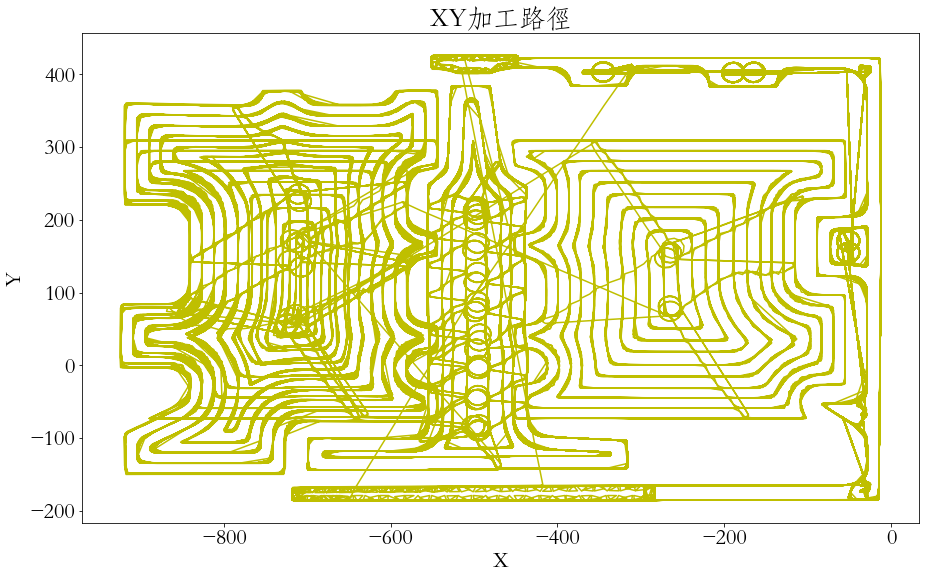

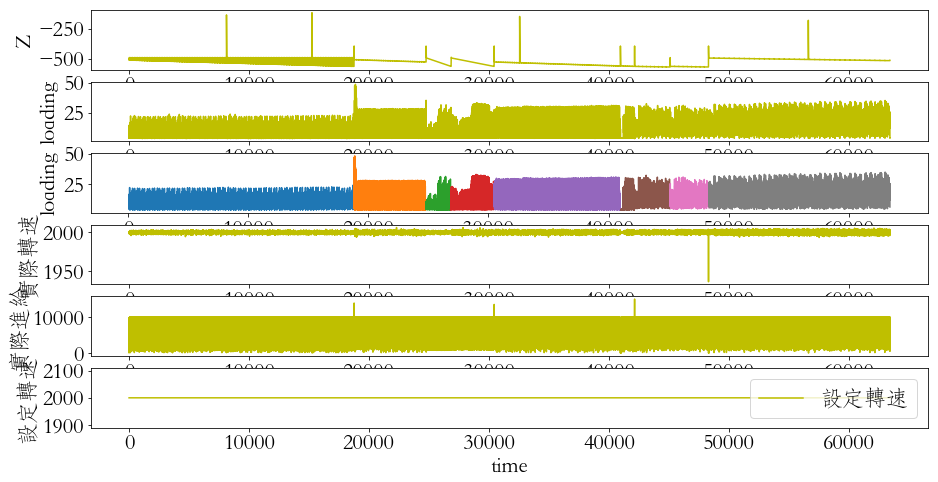

/Users/Zion/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  from ipykernel import kernelapp as app
/Users/Zion/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: DtypeWarning: Columns (12,14) have mixed types. Specify dtype option on import or set low_memory=False.
  from ipykernel import kernelapp as app
/Users/Zion/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  from ipykernel import kernelapp as app


Read_plc() finish!!!
time cost: 0:45:35.921538
Index(['index', 'time_begin', 'time_end', '單節', '主軸負載', 'X軸機械座標', 'Y軸機械座標',
       'Z軸機械座標', '實際進給', '實際轉速', '設定進給', '設定轉速', 'file', '進給率', 'index0',
       'time_diff'],
      dtype='object')


/Users/Zion/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Seg_df() finish!!! time cost: 0:45:53.002426


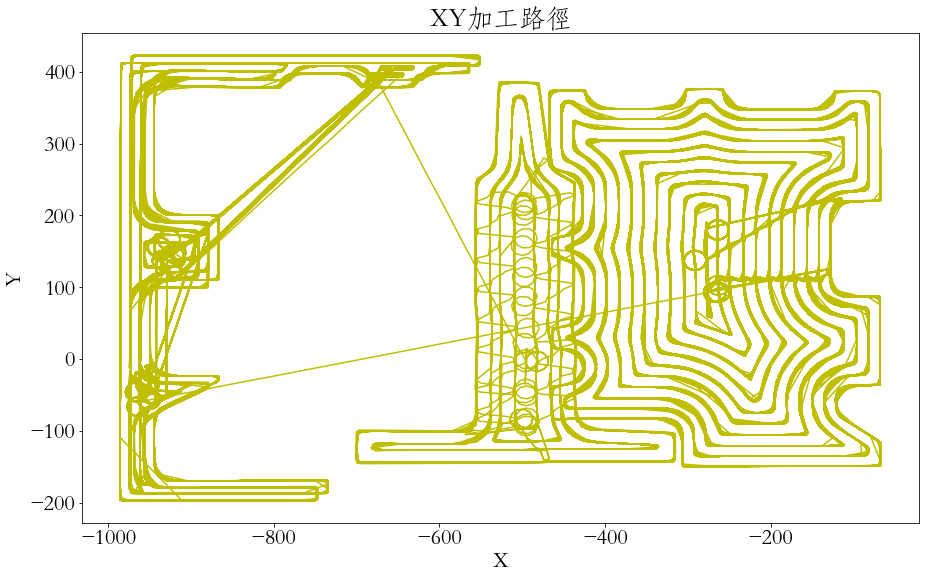

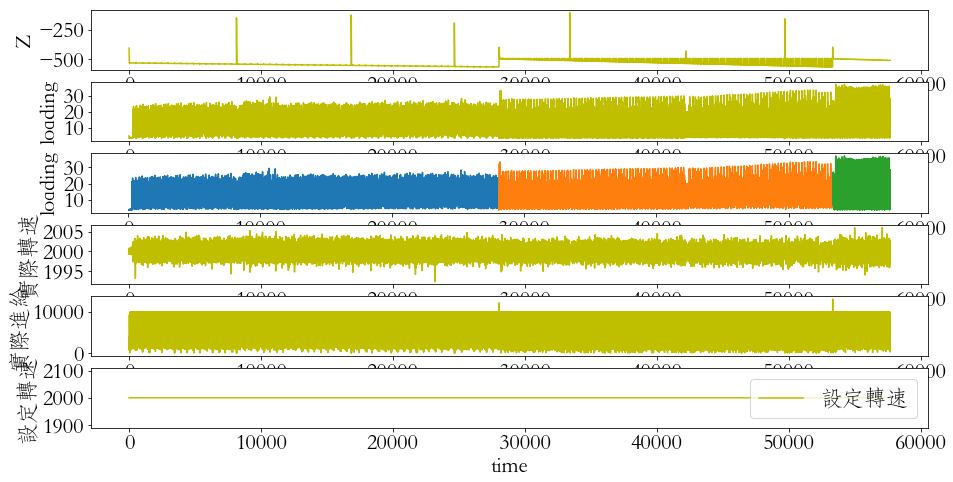

/Users/Zion/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  app.launch_new_instance()
/Users/Zion/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  app.launch_new_instance()
/Users/Zion/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: DtypeWarning: Columns (4,12) have mixed types. Specify dtype option on import or set low_memory=False.
  app.launch_new_instance()


Read_plc() finish!!!
time cost: 0:46:18.807097
Index(['index', 'time_begin', 'time_end', '單節', '主軸負載', 'X軸機械座標', 'Y軸機械座標',
       'Z軸機械座標', '實際進給', '實際轉速', '設定進給', '設定轉速', 'file', '進給率', 'index0',
       'time_diff'],
      dtype='object')


/Users/Zion/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Seg_df() finish!!! time cost: 0:46:44.472663


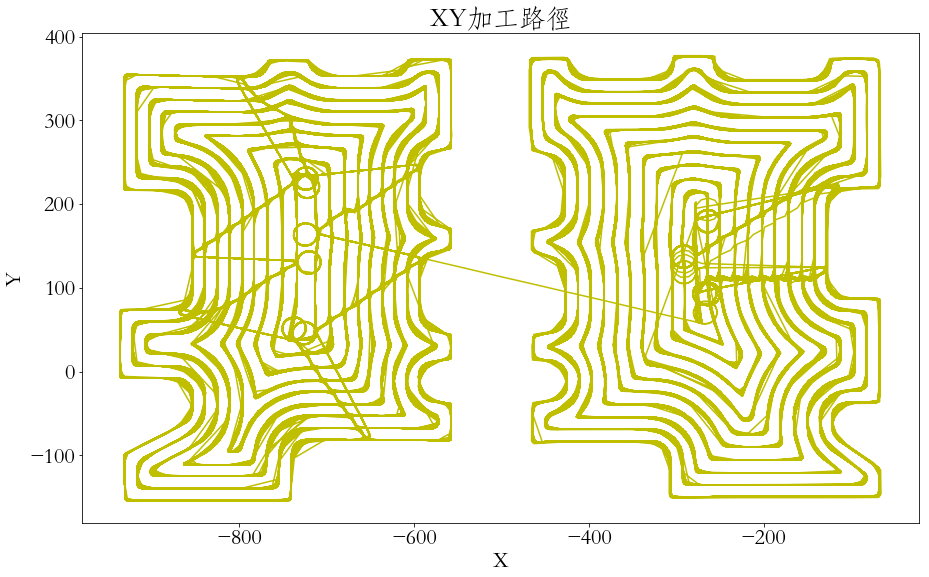

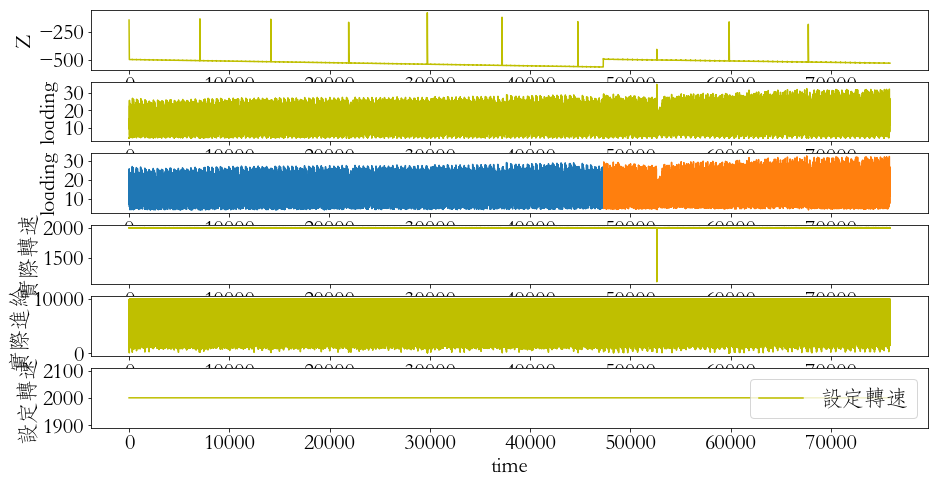

/Users/Zion/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:4: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.


Read_plc() finish!!!
time cost: 0:47:01.743954
Index(['index', 'time_begin', 'time_end', '單節', '主軸負載', 'X軸機械座標', 'Y軸機械座標',
       'Z軸機械座標', '實際進給', '實際轉速', '設定進給', '設定轉速', 'file', '進給率', 'index0',
       'time_diff'],
      dtype='object')
Seg_df() finish!!! time cost: 0:47:19.512464


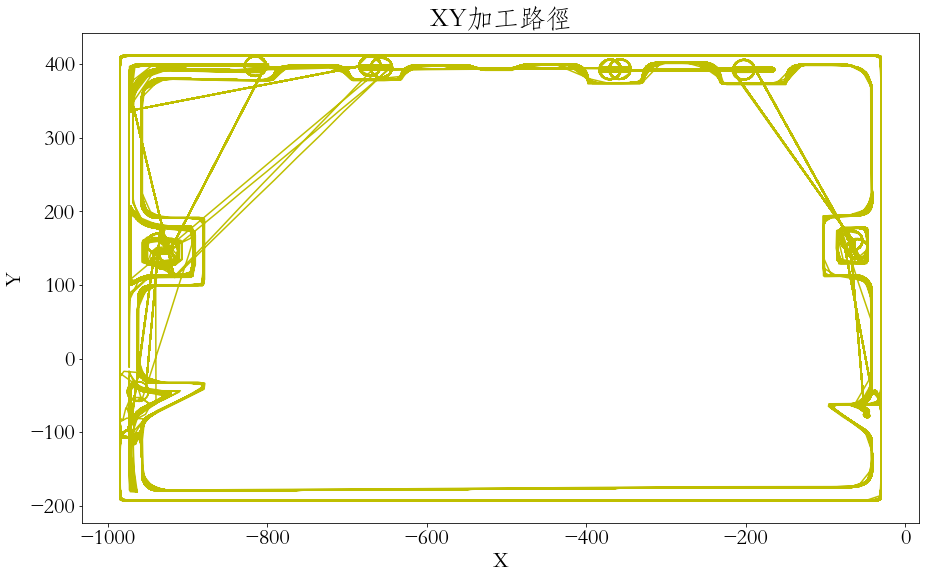

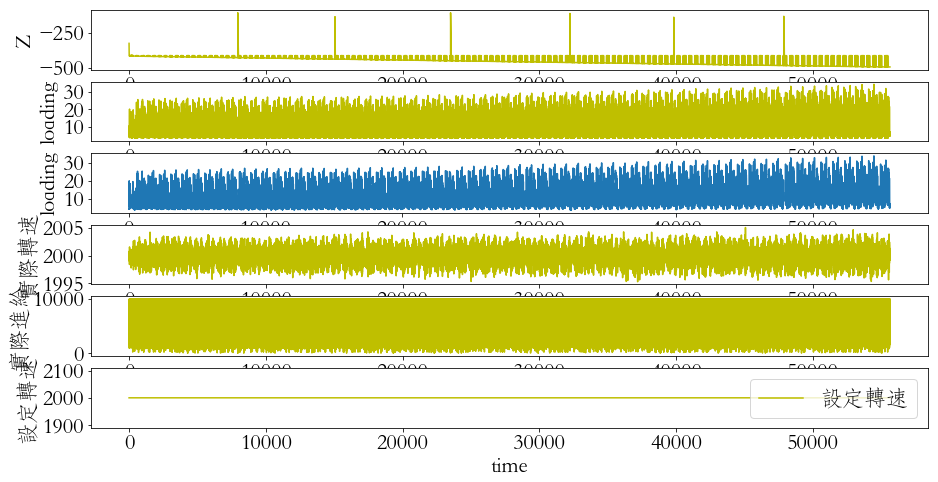

/Users/Zion/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:5: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.


Read_plc() finish!!!
time cost: 0:47:41.356458
Index(['index', 'time_begin', 'time_end', '單節', '主軸負載', 'X軸機械座標', 'Y軸機械座標',
       'Z軸機械座標', '實際進給', '實際轉速', '設定進給', '設定轉速', 'file', '進給率', 'index0',
       'time_diff'],
      dtype='object')


/Users/Zion/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Seg_df() finish!!! time cost: 0:48:05.191302


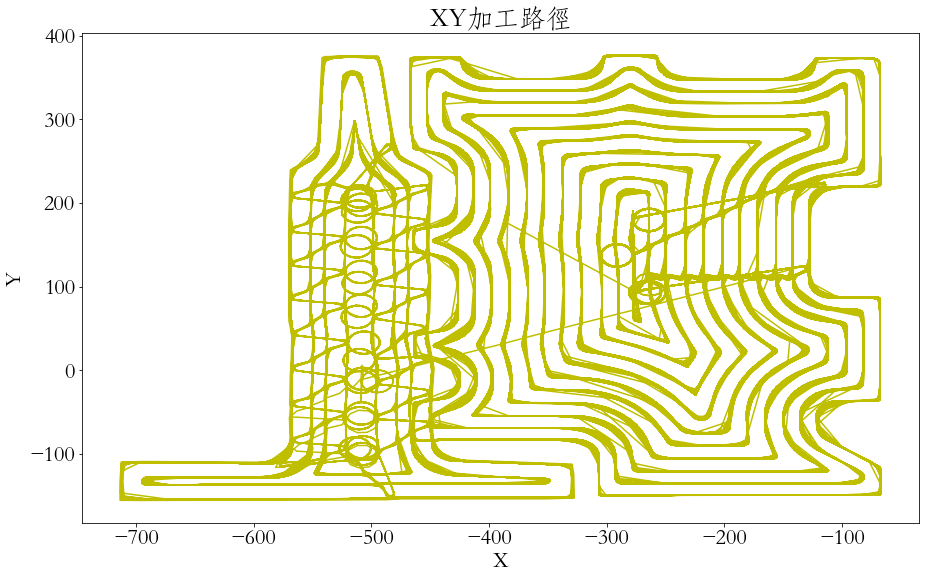

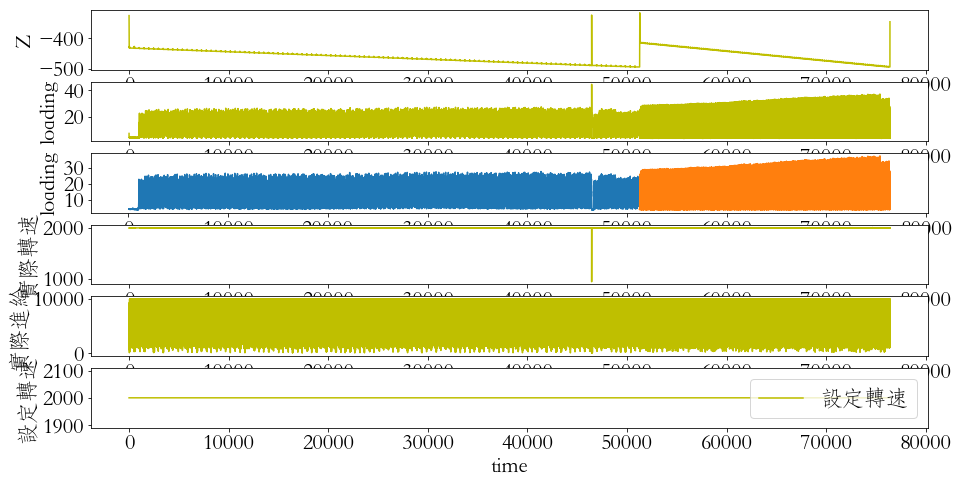

/Users/Zion/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:6: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.


Read_plc() finish!!!
time cost: 0:48:25.964551
Index(['index', 'time_begin', 'time_end', '單節', '主軸負載', 'X軸機械座標', 'Y軸機械座標',
       'Z軸機械座標', '實際進給', '實際轉速', '設定進給', '設定轉速', 'file', '進給率', 'index0',
       'time_diff'],
      dtype='object')


/Users/Zion/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Seg_df() finish!!! time cost: 0:48:48.198080


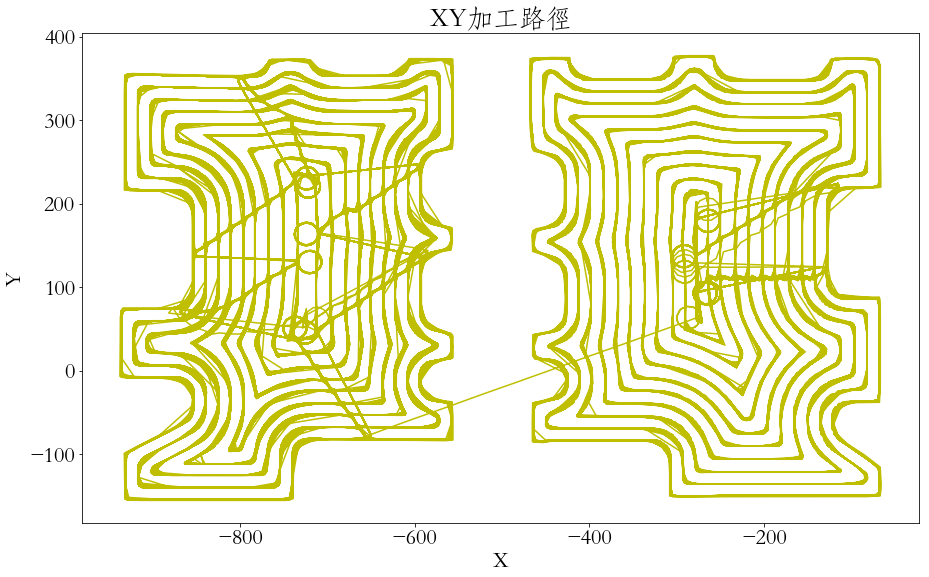

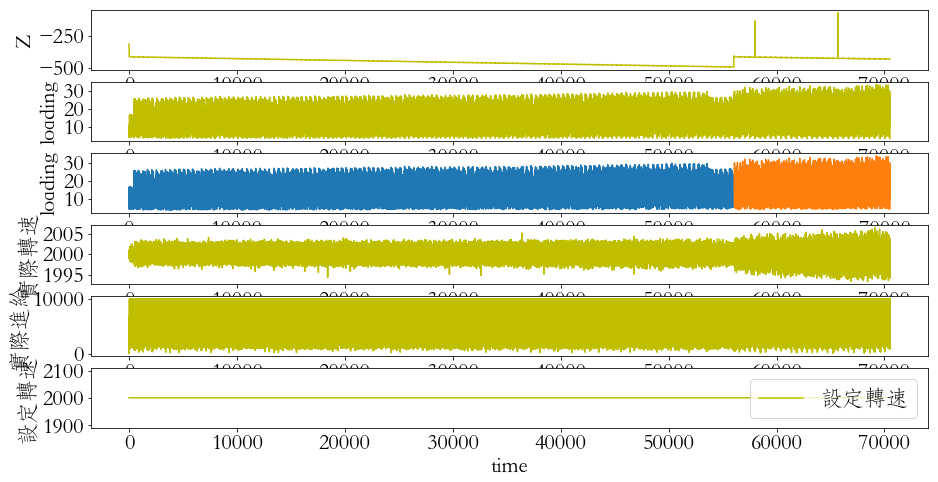

Read_plc() finish!!!
time cost: 0:48:56.587065
Index(['index', 'time_begin', 'time_end', '單節', '主軸負載', 'X軸機械座標', 'Y軸機械座標',
       'Z軸機械座標', '實際進給', '實際轉速', '設定進給', '設定轉速', 'file', '進給率', 'index0',
       'time_diff'],
      dtype='object')
Seg_df() finish!!! time cost: 0:49:03.677799


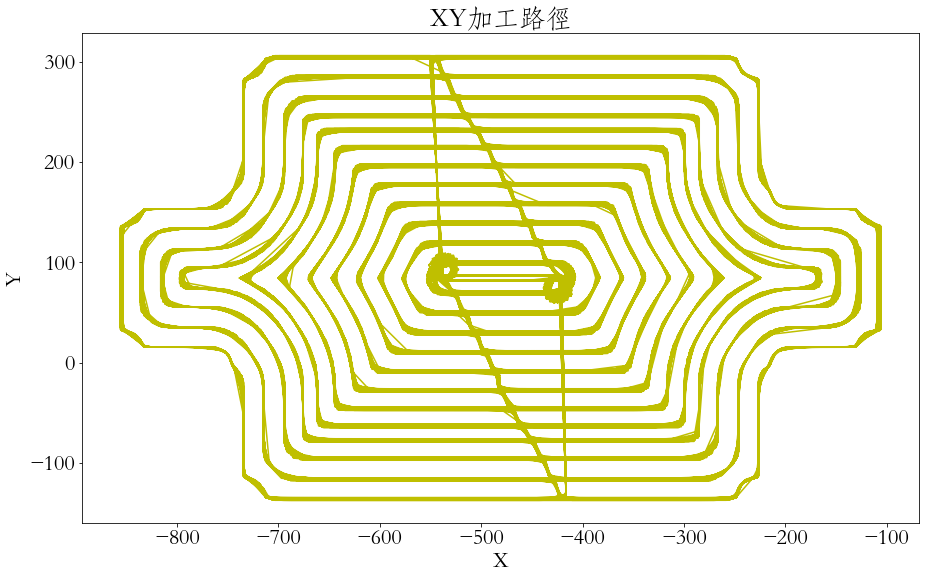

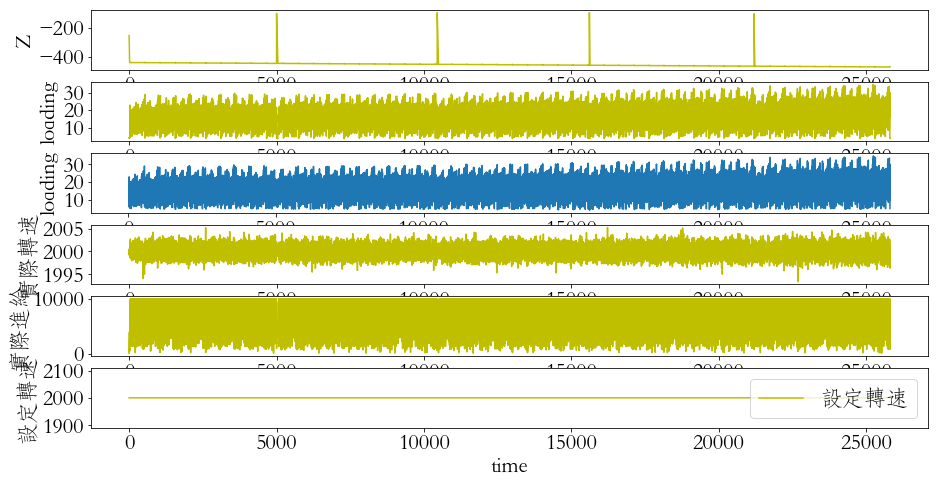

In [21]:
z15 = Deal_plc('/Users/Zion/Downloads/15-PLC/')
z14 = Deal_plc('/Users/Zion/Downloads/14-PLC/')
z13 = Deal_plc('/Users/Zion/Downloads/13-PLC/')
z12 = Deal_plc('/Users/Zion/Downloads/12-PLC/')
z11 = Deal_plc('/Users/Zion/Downloads/11-PLC/')
z10 = Deal_plc('/Users/Zion/Downloads/10-PLC/')
z9 = Deal_plc('/Users/Zion/Downloads/9-PLC/')

/Users/Zion/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  from ipykernel import kernelapp as app


Read_plc() finish!!!
time cost: 22:07:17.324426
Index(['index', 'time_begin', 'time_end', '單節', '主軸負載', 'X軸機械座標', 'Y軸機械座標',
       'Z軸機械座標', '實際進給', '實際轉速', '設定進給', '設定轉速', 'file', '進給率', 'index0',
       'time_diff'],
      dtype='object')


/Users/Zion/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Seg_df() finish!!! time cost: 22:07:36.905917


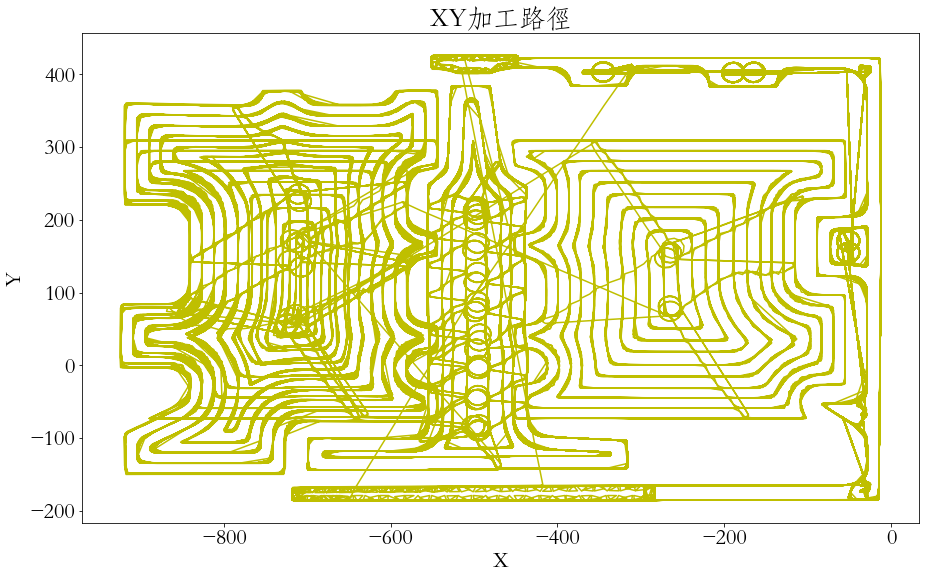

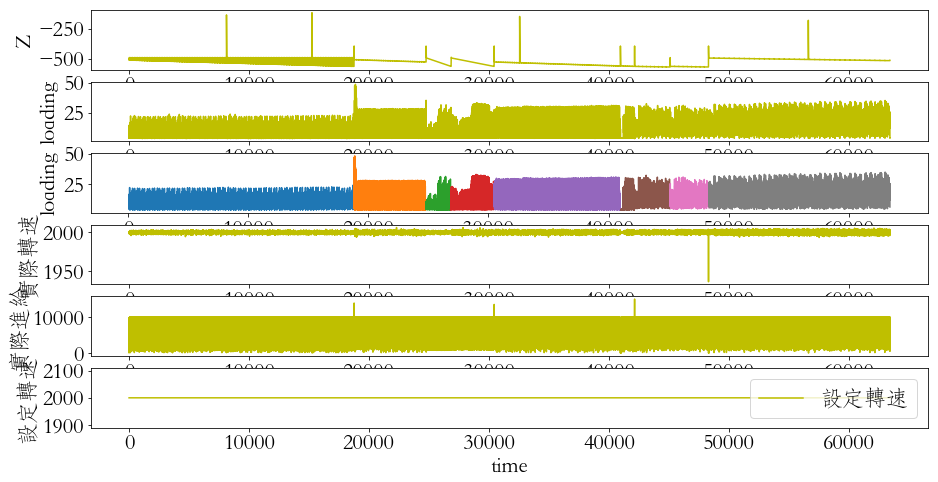

             path       layer       count        mean         std        rms2  \
count  432.000000  432.000000  432.000000  432.000000  432.000000  432.000000   
mean     3.520833   43.863426  104.611111   11.128009    5.780093   12.633852   
std      1.885229   30.461453  112.157338    3.303444    2.286371    3.708403   
min      1.000000    2.000000   13.000000    5.700000    1.600000    5.901742   
25%      2.000000   18.000000   16.000000    8.300000    4.300000   10.235881   
50%      3.000000   37.000000   28.000000   10.300000    5.300000   11.445635   
75%      4.000000   67.000000  173.000000   13.325000    7.000000   15.120925   
max      8.000000  112.000000  412.000000   18.700000   12.600000   19.434423   

              max         min         p25         p75          h0          h5  \
count  432.000000  432.000000  432.000000  432.000000  432.000000  432.000000   
mean    24.415874    4.062120    6.325323   15.216100   12.886574   20.527778   
std      6.645690    0.2731

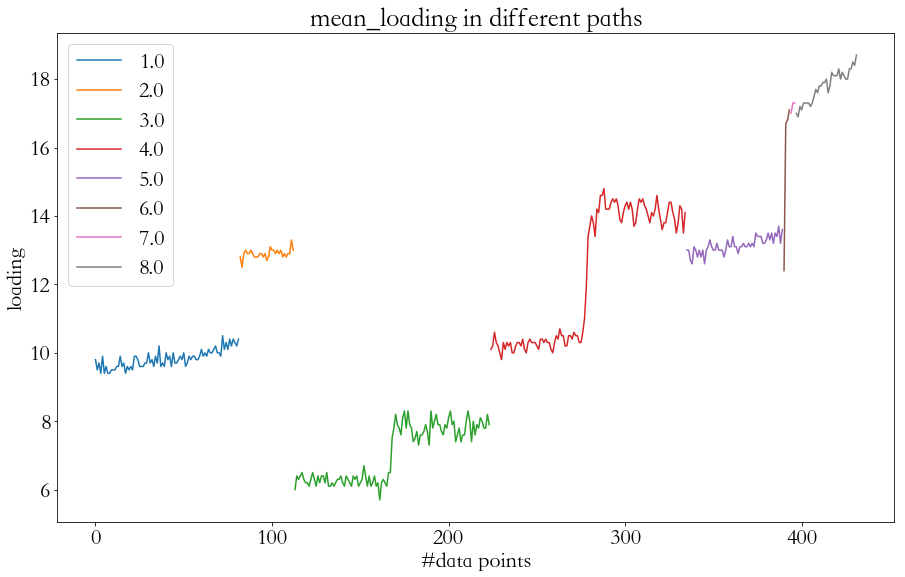

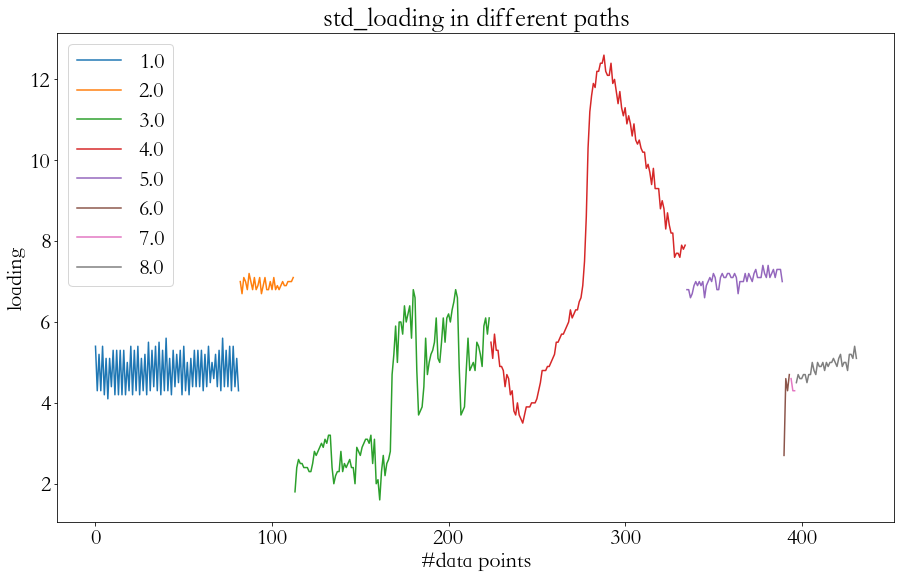

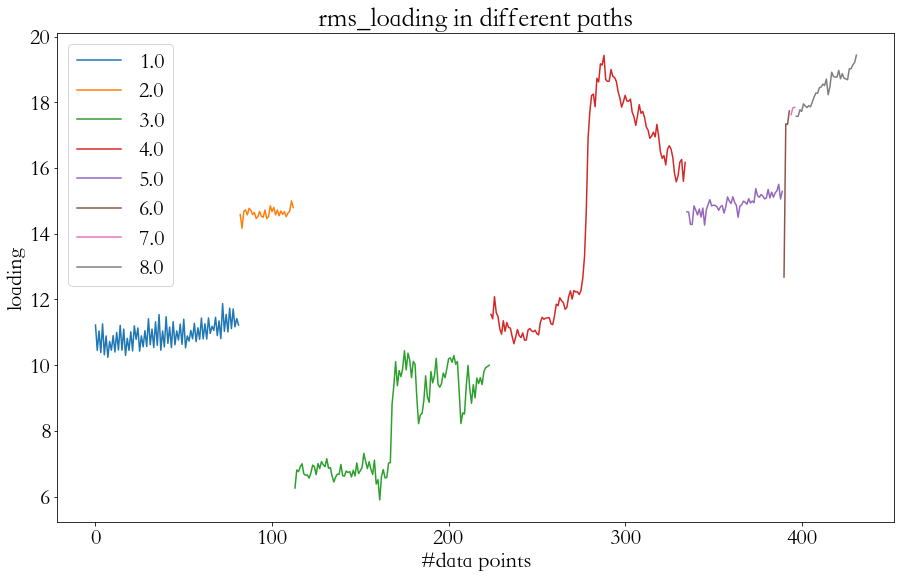

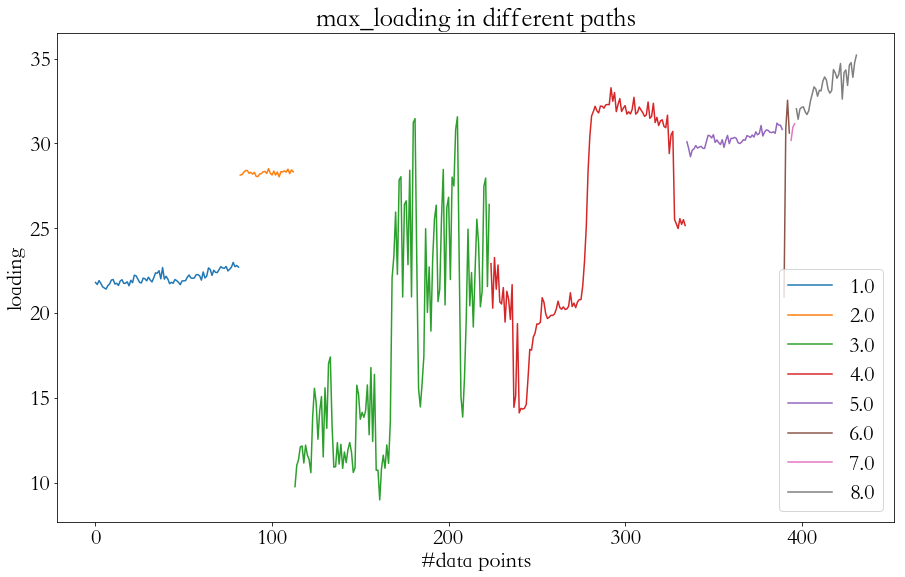

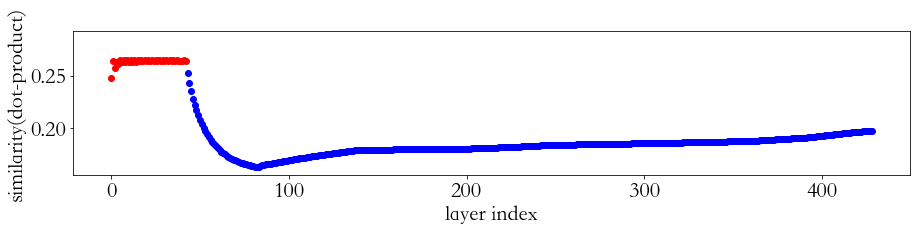

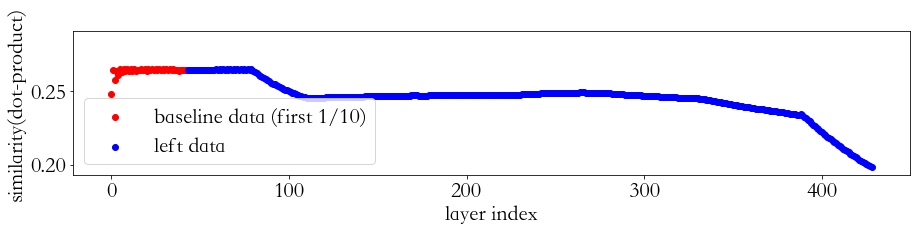

In [24]:
t15 = Dras_stat(Deal_plc('/Users/Zion/Downloads/15-PLC/'))
Draw_Corr_End_To_First(t15)
Draw_Corr(t15)


/Users/Zion/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  if __name__ == '__main__':
/Users/Zion/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: DtypeWarning: Columns (12,14) have mixed types. Specify dtype option on import or set low_memory=False.
  if __name__ == '__main__':
/Users/Zion/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  if __name__ == '__main__':


Read_plc() finish!!!
time cost: 22:10:45.669091
Index(['index', 'time_begin', 'time_end', '單節', '主軸負載', 'X軸機械座標', 'Y軸機械座標',
       'Z軸機械座標', '實際進給', '實際轉速', '設定進給', '設定轉速', 'file', '進給率', 'index0',
       'time_diff'],
      dtype='object')


/Users/Zion/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Seg_df() finish!!! time cost: 22:11:03.050104


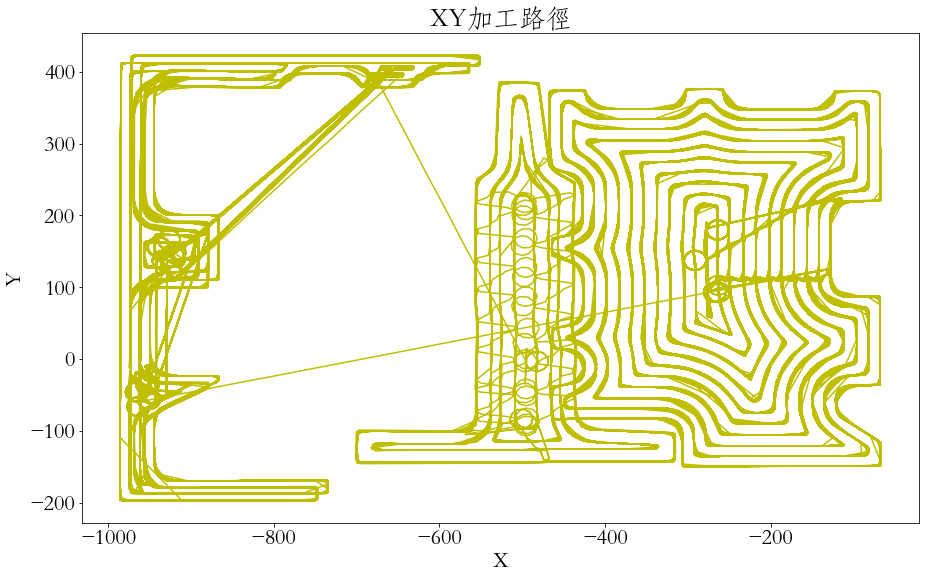

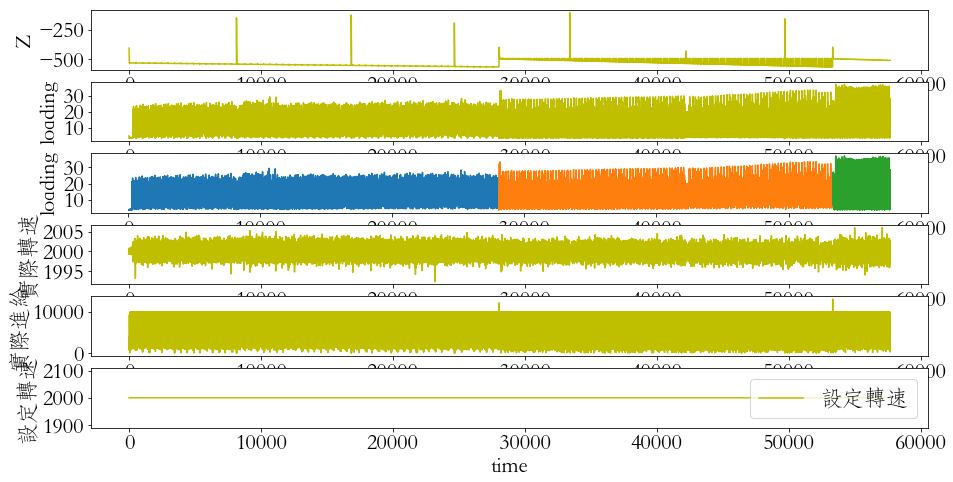

             path       layer       count        mean         std        rms2  \
count  184.000000  184.000000  184.000000  184.000000  184.000000  184.000000   
mean     1.836957   43.043478  244.255435   13.006522    5.758696   14.292528   
std      0.614527   31.057117  127.348646    1.738148    1.513809    1.819084   
min      1.000000    2.000000  152.000000   10.400000    3.600000   11.947617   
25%      1.000000   17.000000  162.000000   11.400000    4.000000   12.879180   
50%      2.000000   36.500000  165.000000   13.100000    6.000000   14.122440   
75%      2.000000   65.250000  444.250000   14.200000    6.200000   14.901624   
max      3.000000  111.000000  458.000000   16.600000    9.100000   18.869128   

              max         min         p25         p75          h0          h5  \
count  184.000000  184.000000  184.000000  184.000000  184.000000  184.000000   
mean    29.414552    4.326911    8.557203   15.923352   10.684783   57.146739   
std      3.267410    0.3159

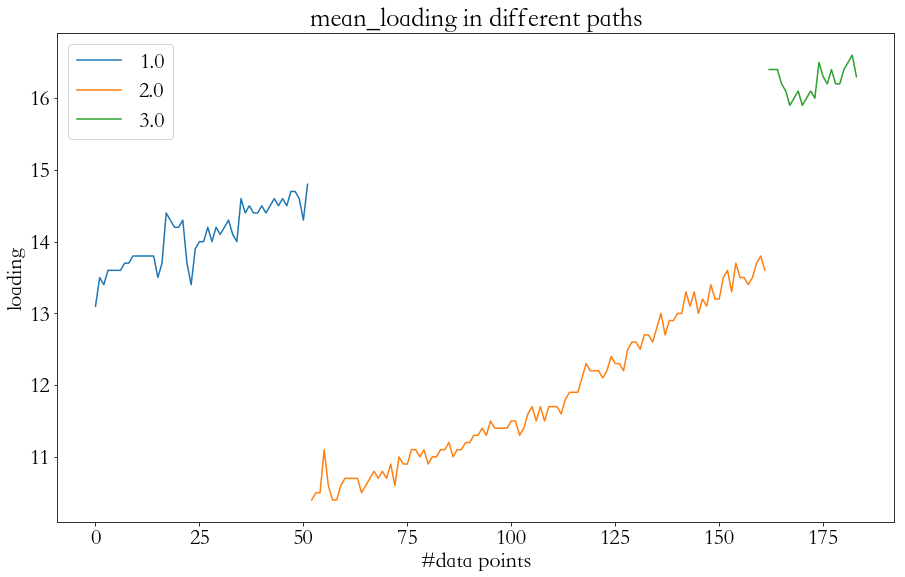

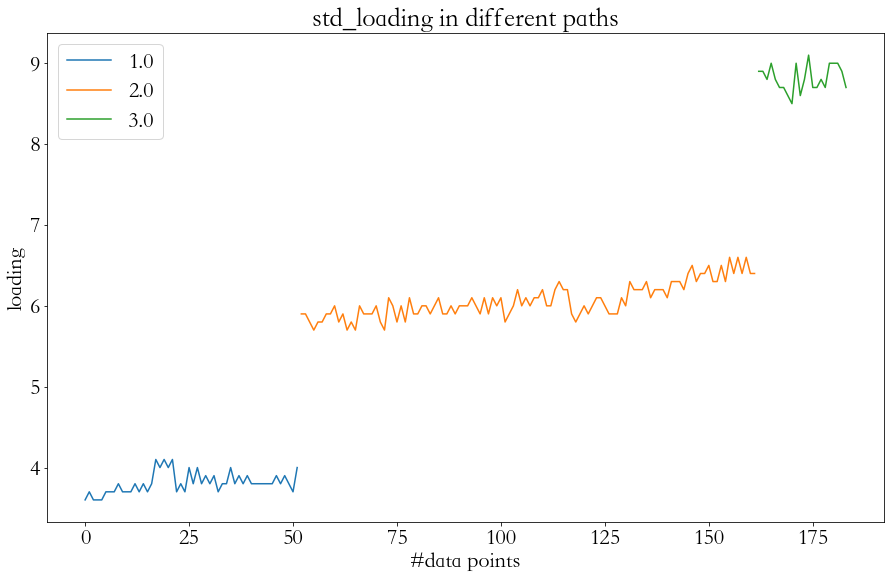

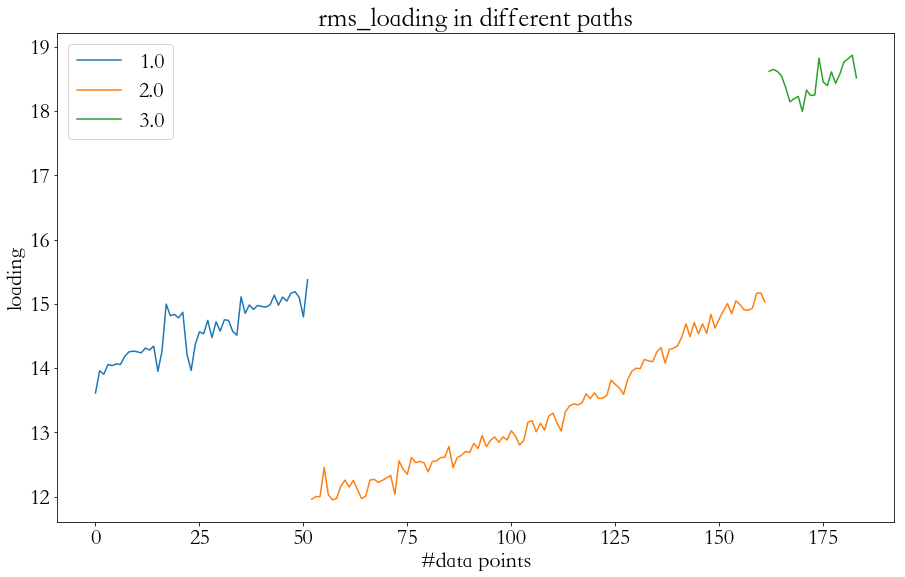

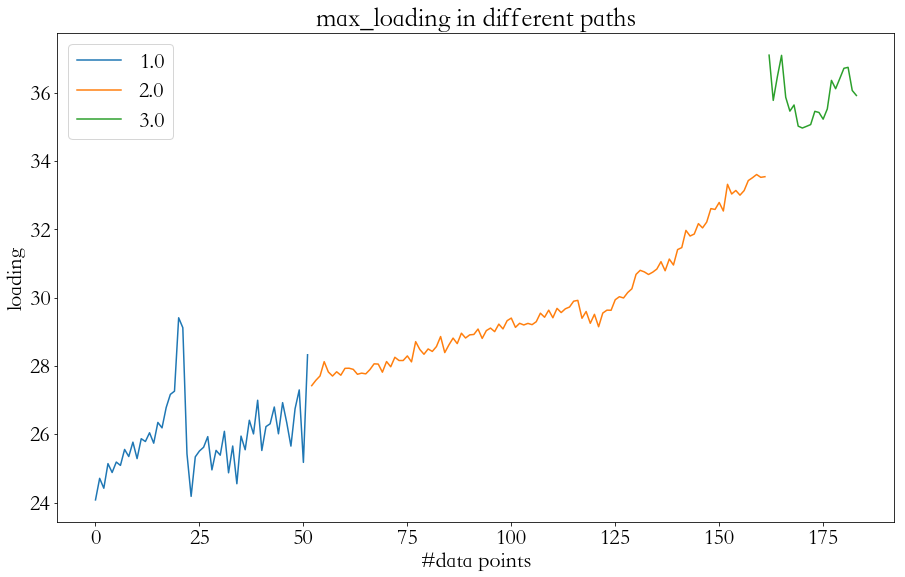

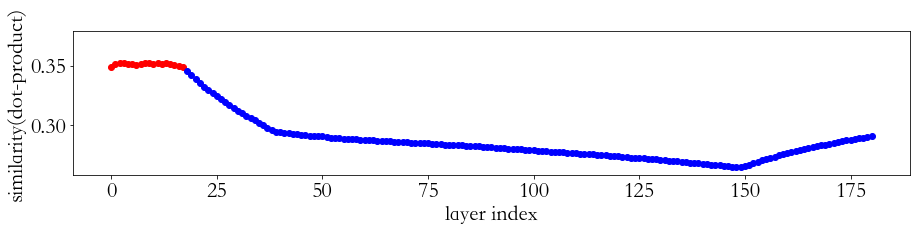

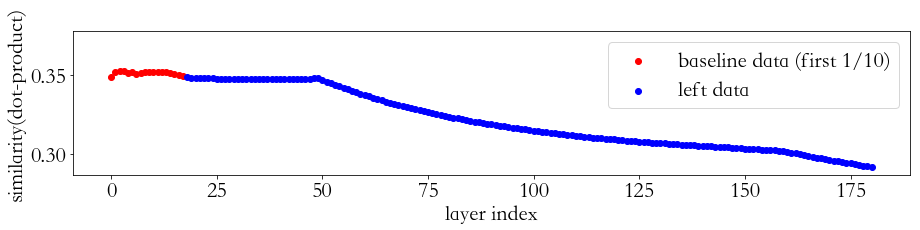

In [25]:
t14 = Dras_stat(Deal_plc('/Users/Zion/Downloads/14-PLC/'))
Draw_Corr_End_To_First(t14)
Draw_Corr(t14)

/Users/Zion/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  if __name__ == '__main__':
/Users/Zion/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  if __name__ == '__main__':
/Users/Zion/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: DtypeWarning: Columns (4,12) have mixed types. Specify dtype option on import or set low_memory=False.
  if __name__ == '__main__':


Read_plc() finish!!!
time cost: 22:12:34.767682
Index(['index', 'time_begin', 'time_end', '單節', '主軸負載', 'X軸機械座標', 'Y軸機械座標',
       'Z軸機械座標', '實際進給', '實際轉速', '設定進給', '設定轉速', 'file', '進給率', 'index0',
       'time_diff'],
      dtype='object')


/Users/Zion/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Seg_df() finish!!! time cost: 22:13:00.619295


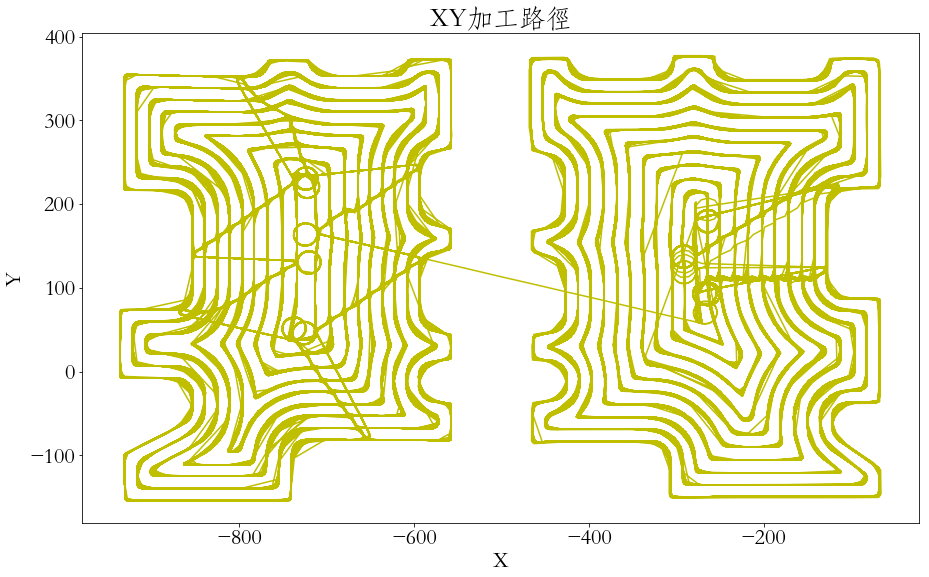

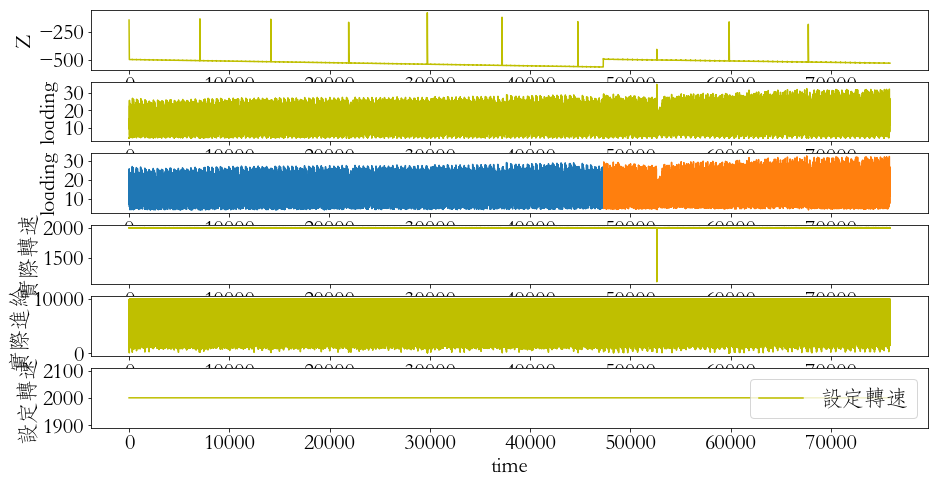

             path       layer       count        mean         std        rms2  \
count  166.000000  166.000000  166.000000  166.000000  166.000000  166.000000   
mean     1.355422   46.469880  416.433735   15.439157    4.231325   16.007126   
std      0.480089   29.242285   31.481671    1.071152    0.310201    1.109757   
min      1.000000    2.000000  117.000000   12.600000    3.300000   13.047064   
25%      1.000000   22.250000  402.000000   14.700000    4.000000   15.213119   
50%      1.000000   43.000000  404.000000   15.100000    4.150000   15.665170   
75%      2.000000   66.750000  446.000000   16.200000    4.400000   16.763338   
max      2.000000  108.000000  457.000000   18.200000    5.100000   18.680146   

              max         min         p25         p75          h0          h5  \
count  166.000000  166.000000  166.000000  166.000000  166.000000  166.000000   
mean    28.406960    4.569853   12.547106   18.062325    3.506024   32.909639   
std      1.907493    0.3409

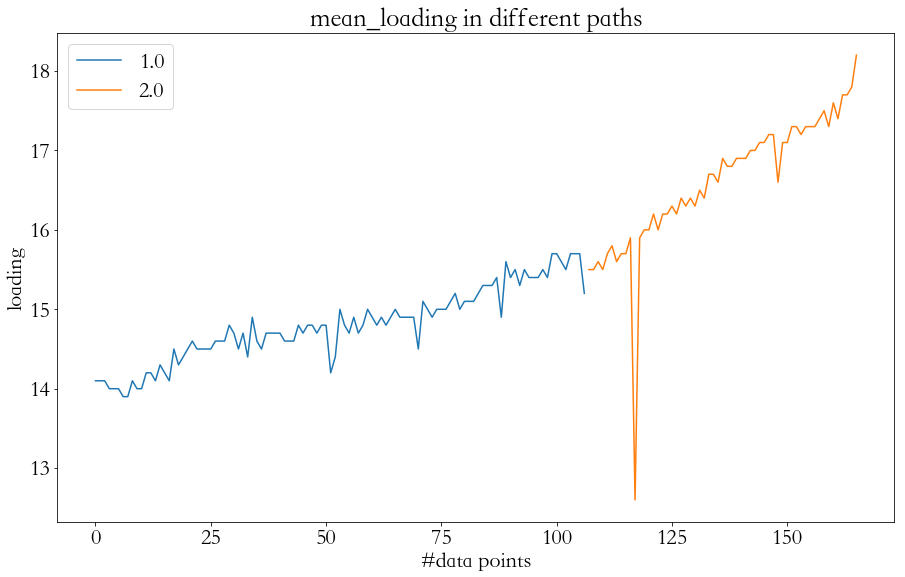

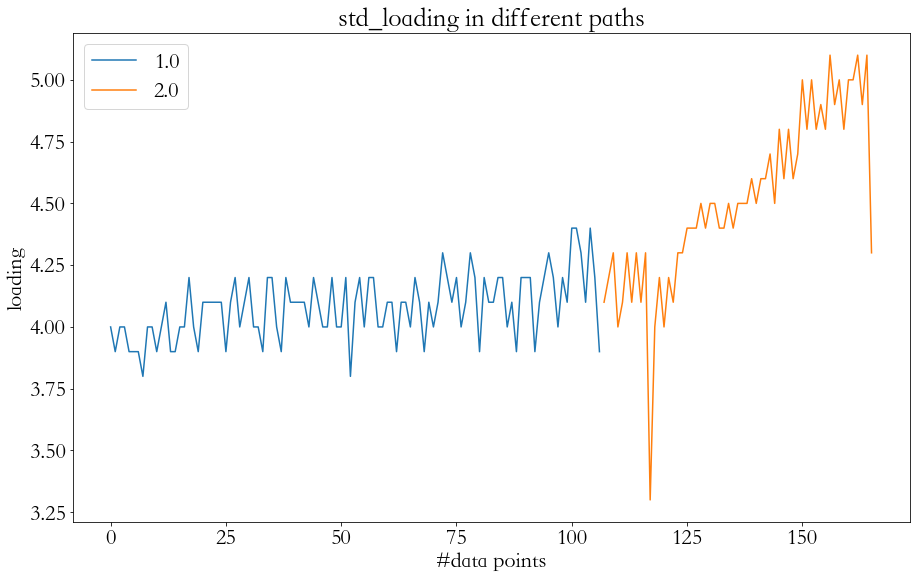

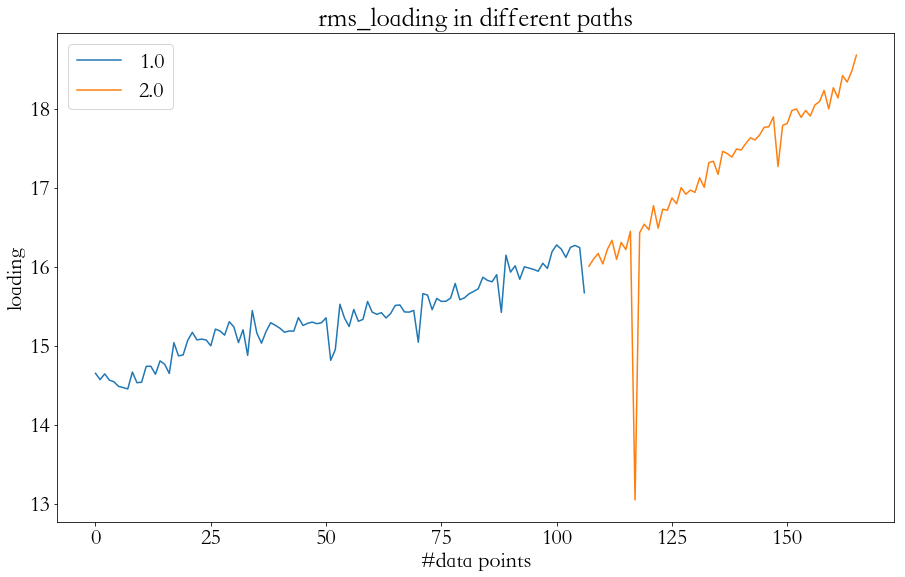

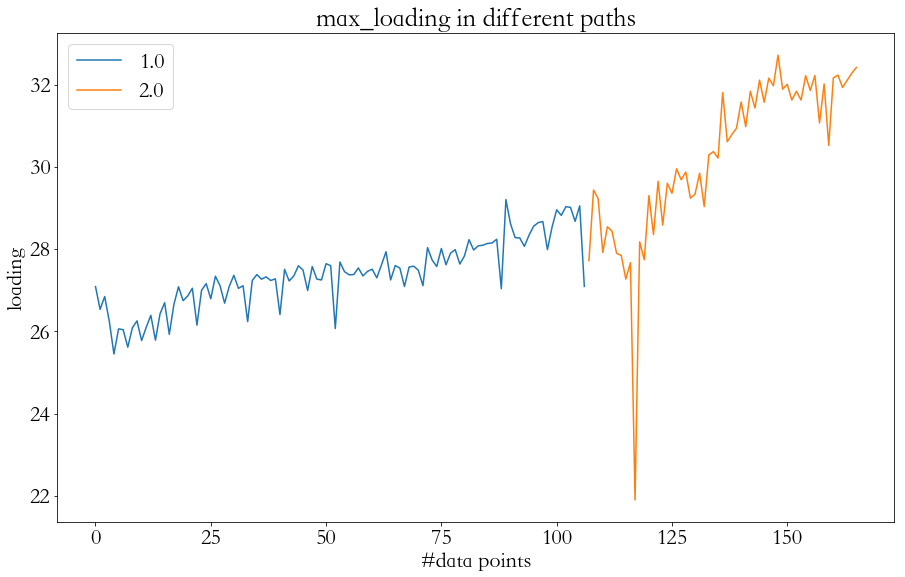

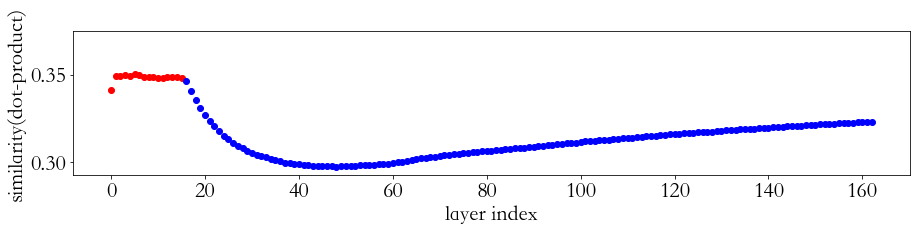

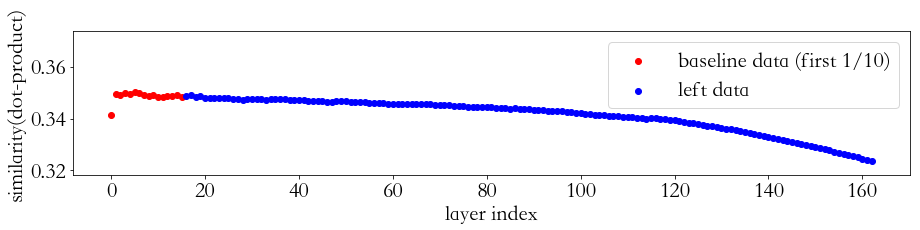

In [26]:
t13 = Dras_stat(Deal_plc('/Users/Zion/Downloads/13-PLC/'))
Draw_Corr_End_To_First(t13)
Draw_Corr(t13)

/Users/Zion/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  if __name__ == '__main__':


Read_plc() finish!!!
time cost: 22:20:58.147707
Index(['index', 'time_begin', 'time_end', '單節', '主軸負載', 'X軸機械座標', 'Y軸機械座標',
       'Z軸機械座標', '實際進給', '實際轉速', '設定進給', '設定轉速', 'file', '進給率', 'index0',
       'time_diff'],
      dtype='object')
Seg_df() finish!!! time cost: 22:21:14.089800


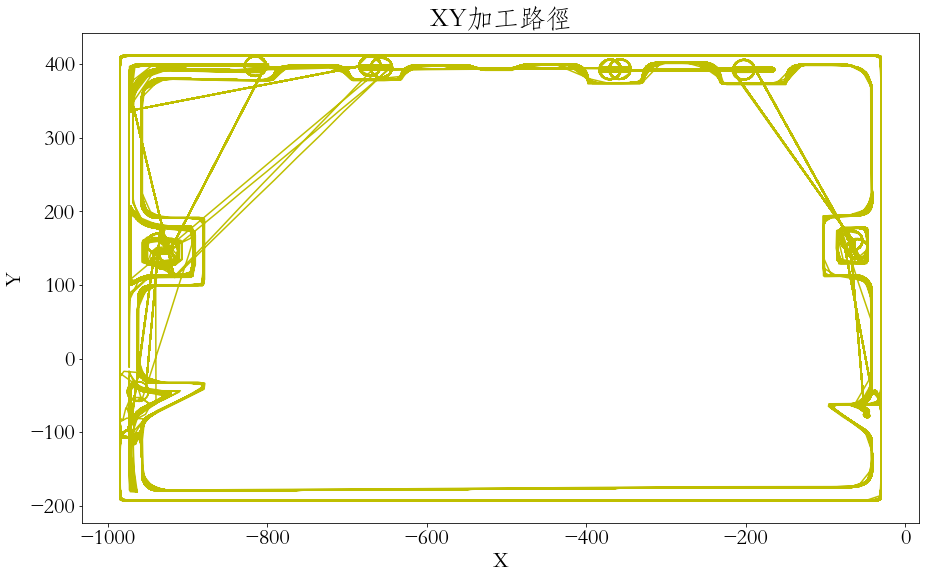

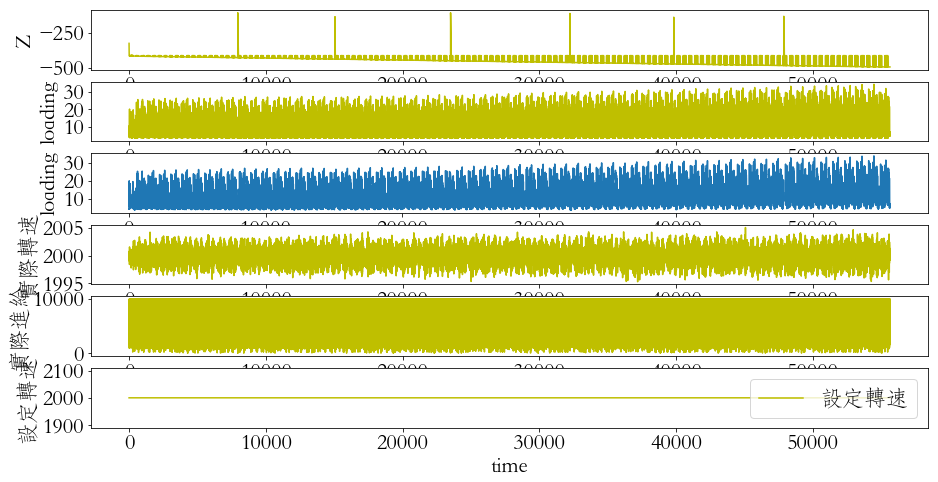

        path       layer       count        mean         std        rms2  \
count  128.0  128.000000  128.000000  128.000000  128.000000  128.000000   
mean     1.0   65.500000  268.109375   11.653906    5.468750   12.898904   
std      0.0   37.094474    6.872557    1.118203    1.018471    1.262935   
min      1.0    2.000000  253.000000    9.600000    4.100000   11.017436   
25%      1.0   33.750000  262.000000   10.700000    4.500000   11.881932   
50%      1.0   65.500000  267.500000   11.500000    5.500000   12.662514   
75%      1.0   97.250000  275.000000   12.600000    6.300000   13.822475   
max      1.0  129.000000  286.000000   14.000000    7.400000   15.876622   

              max         min         p25         p75          h0          h5  \
count  128.000000  128.000000  128.000000  128.000000  128.000000  128.000000   
mean    28.111505    4.177817    6.959299   15.244752   29.546875   86.500000   
std      2.604335    0.203935    1.548120    1.627897   23.814526   13.4

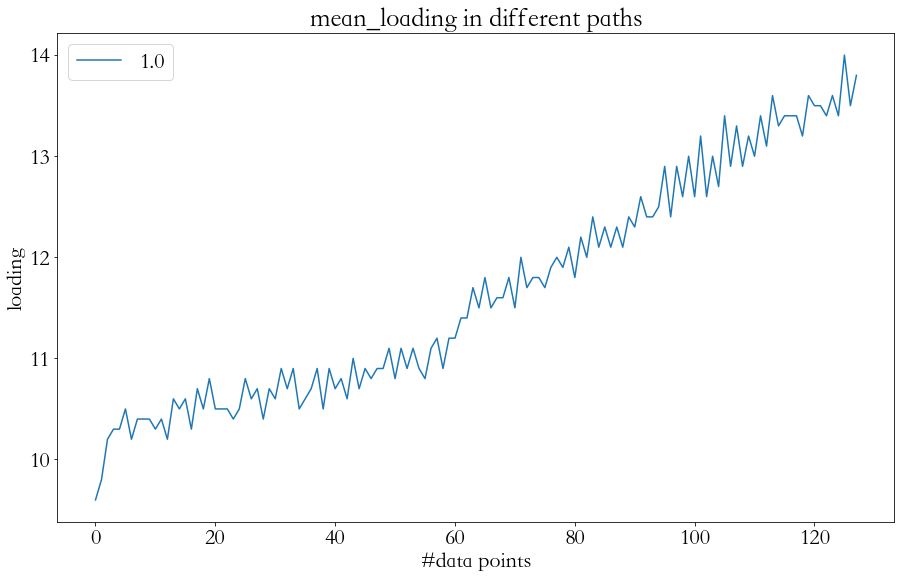

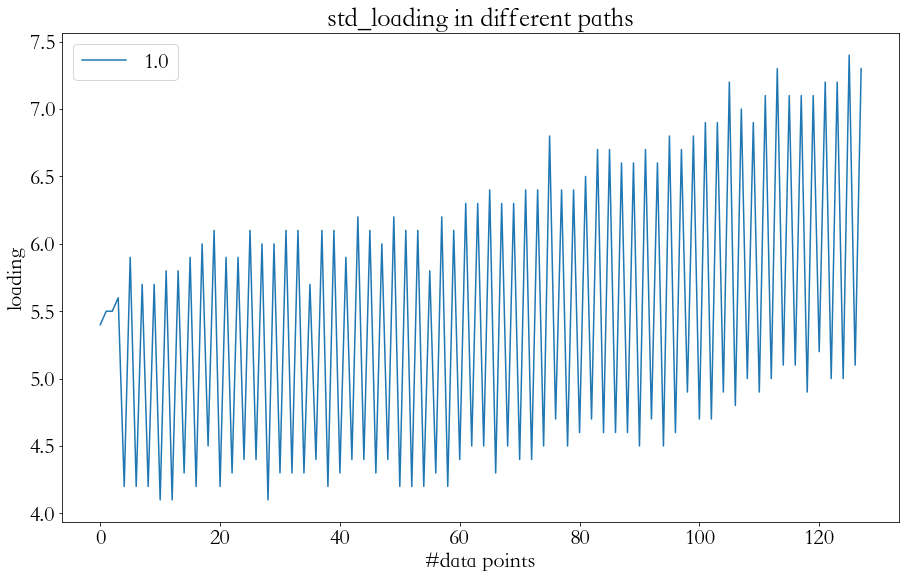

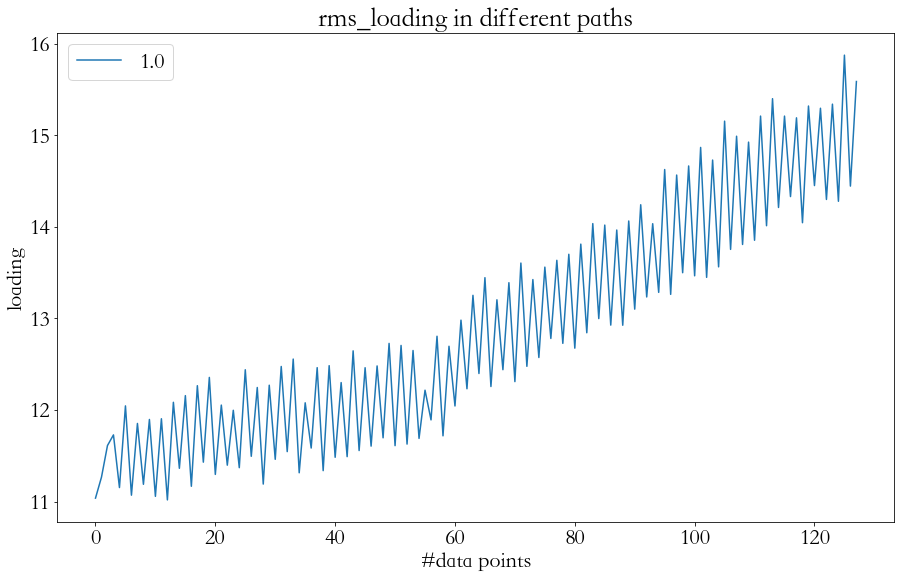

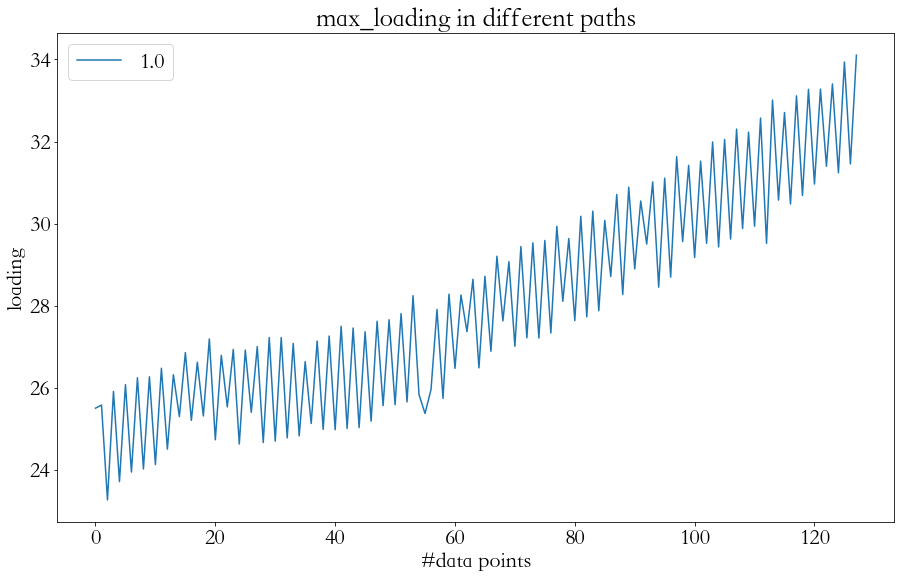

     h0    h5  h10  h15  h20  h25  h30  h35
0    63    80   57   44   19    0    0    0
1   131   162  122   85   37    2    0    0
2   163   258  235   97   47    2    0    0
3   231   337  296  144   66    4    0    0
4   262   433  410  154   77    4    0    0
5   325   517  480  192   93    7    0    0
6   356   617  588  204  105    7    0    0
7   422   700  656  242  124   10    0    0
8   454   797  767  254  133   10    0    0
9   522   876  832  299  149   12    0    0
10  549   989  933  311  157   12    0    0
11  614  1070  997  357  173   15    0    0


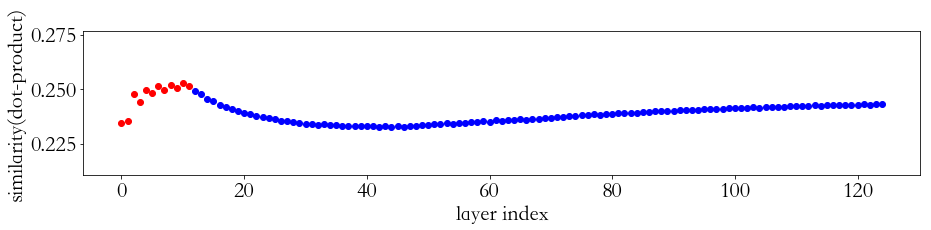

     h0    h5  h10  h15  h20  h25  h30  h35
2    63    80   57   44   19    0    0    0
3   131   162  122   85   37    2    0    0
4   163   258  235   97   47    2    0    0
5   231   337  296  144   66    4    0    0
6   262   433  410  154   77    4    0    0
7   325   517  480  192   93    7    0    0
8   356   617  588  204  105    7    0    0
9   422   700  656  242  124   10    0    0
10  454   797  767  254  133   10    0    0
11  522   876  832  299  149   12    0    0
12  549   989  933  311  157   12    0    0
13  614  1070  997  357  173   15    0    0


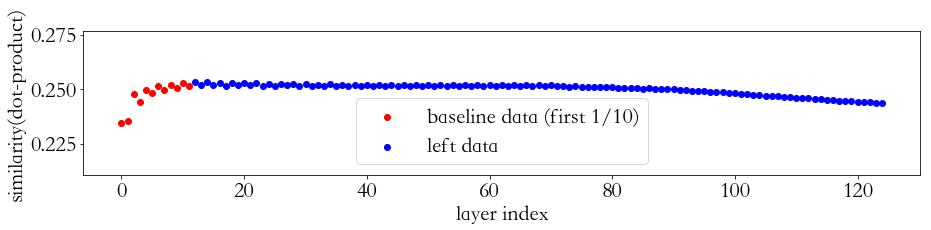

In [33]:
t12 = Dras_stat(Deal_plc('/Users/Zion/Downloads/12-PLC/'))
Draw_Corr_End_To_First(t12)
Draw_Corr(t12)

/Users/Zion/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  if __name__ == '__main__':


Read_plc() finish!!!
time cost: 22:14:05.197497
Index(['index', 'time_begin', 'time_end', '單節', '主軸負載', 'X軸機械座標', 'Y軸機械座標',
       'Z軸機械座標', '實際進給', '實際轉速', '設定進給', '設定轉速', 'file', '進給率', 'index0',
       'time_diff'],
      dtype='object')


/Users/Zion/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Seg_df() finish!!! time cost: 22:14:28.117062


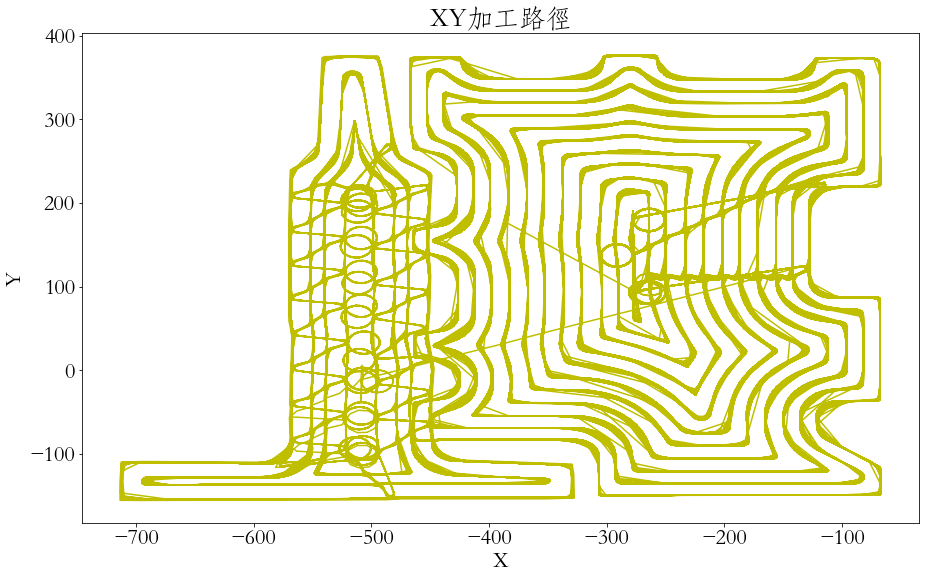

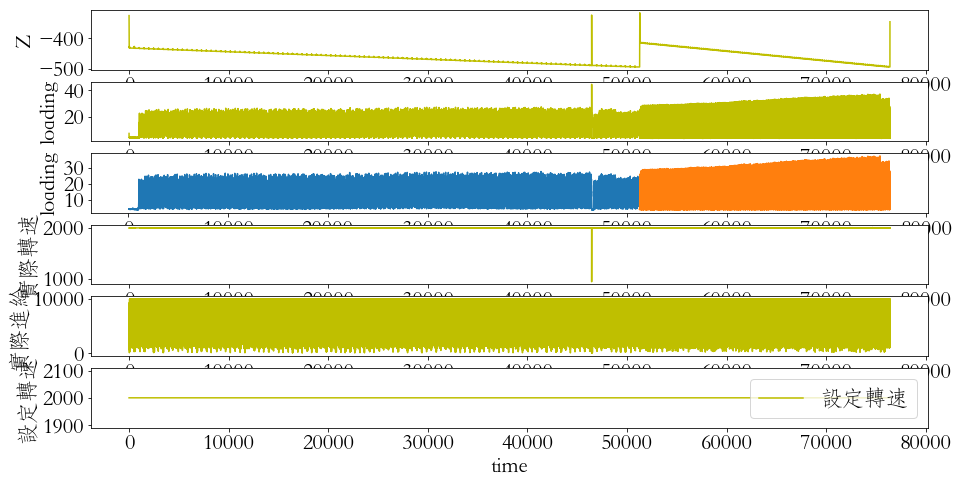

             path       layer       count        mean         std        rms2  \
count  228.000000  228.000000  228.000000  228.000000  228.000000  228.000000   
mean     1.561404   59.359649  294.333333   14.463596    6.257018   15.877074   
std      0.497307   34.429300  137.018611    1.126743    2.202900    1.569829   
min      1.000000    2.000000  170.000000    4.200000    0.200000    4.215253   
25%      1.000000   30.000000  174.000000   13.900000    3.900000   14.917622   
50%      2.000000   58.500000  175.000000   14.450000    7.200000   15.444135   
75%      2.000000   87.000000  446.000000   15.000000    8.300000   17.063965   
max      2.000000  129.000000  643.000000   16.700000    9.300000   19.097220   

              max         min         p25         p75          h0          h5  \
count  228.000000  228.000000  228.000000  228.000000  228.000000  228.000000   
mean    29.707788    4.068840    9.202519   18.554919   19.385965   40.710526   
std      4.077591    0.3028

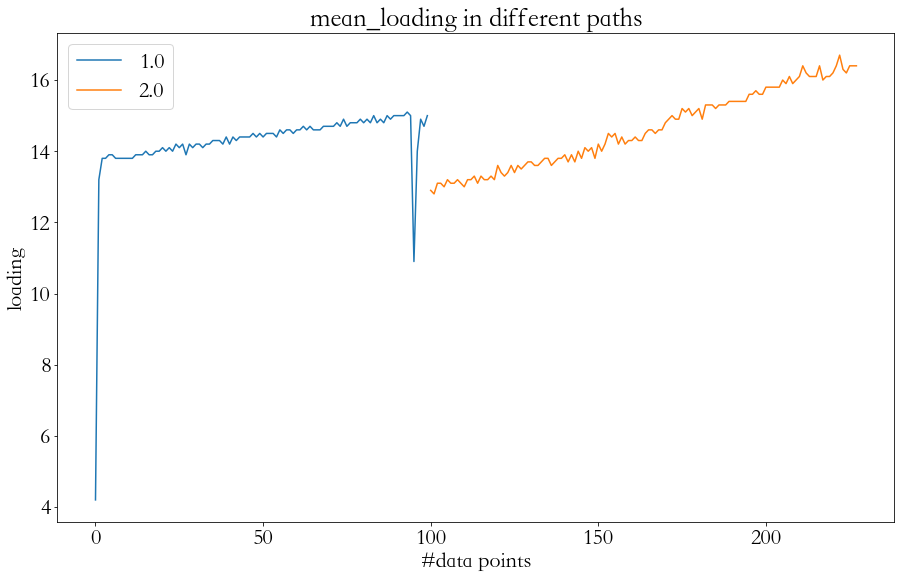

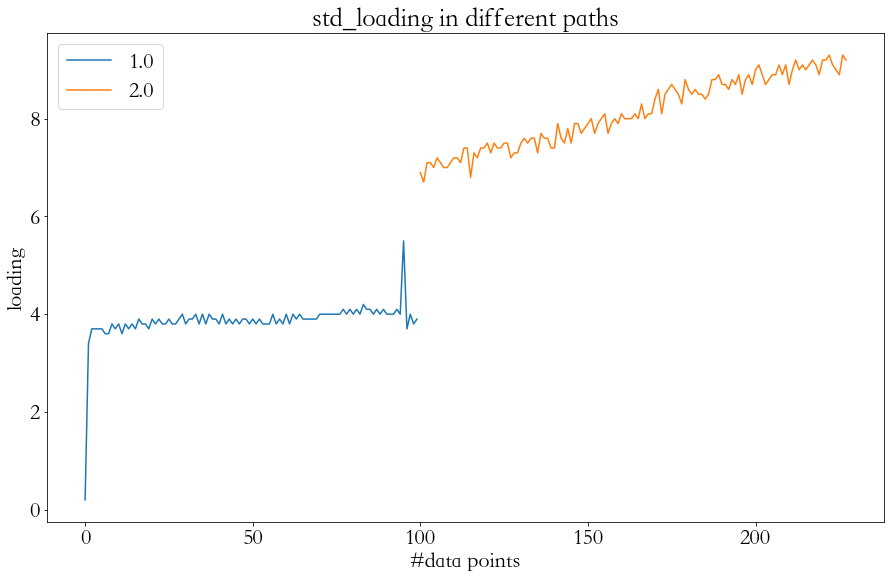

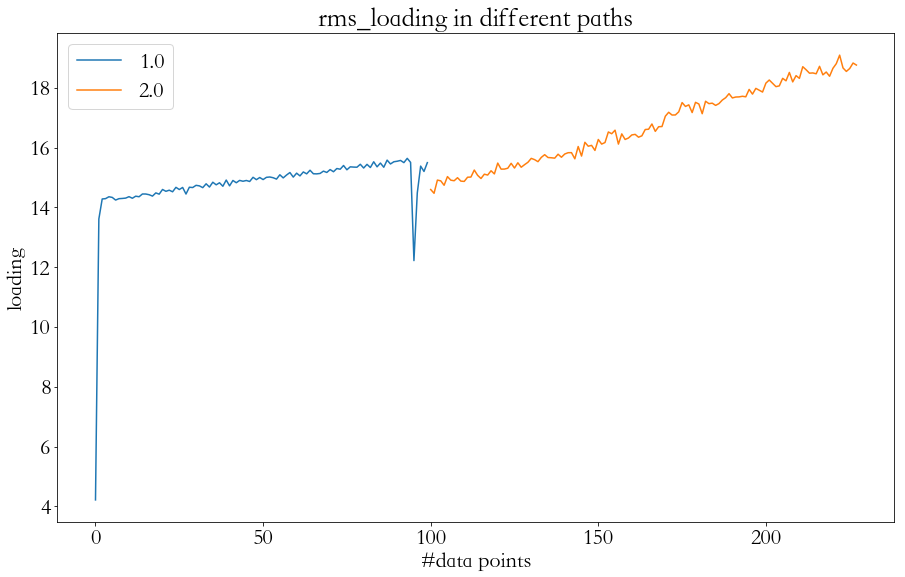

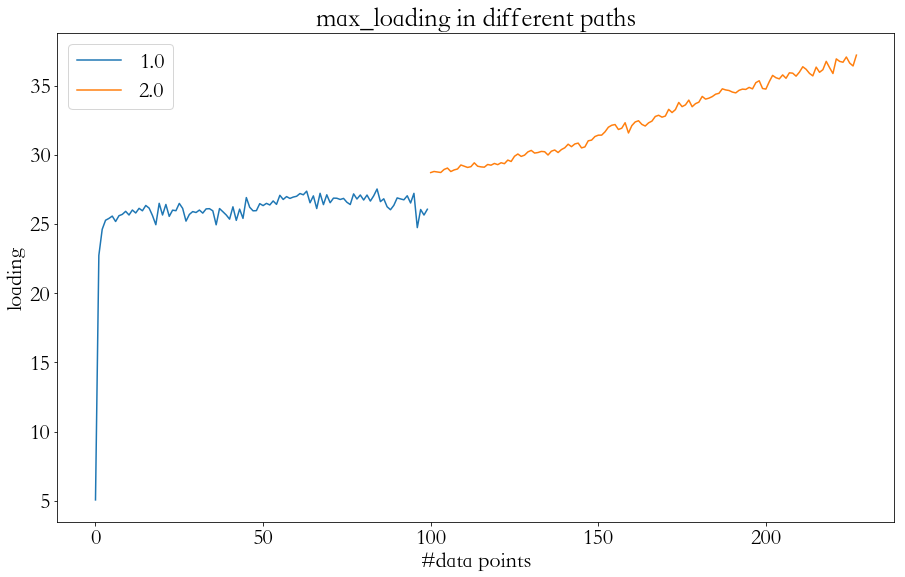

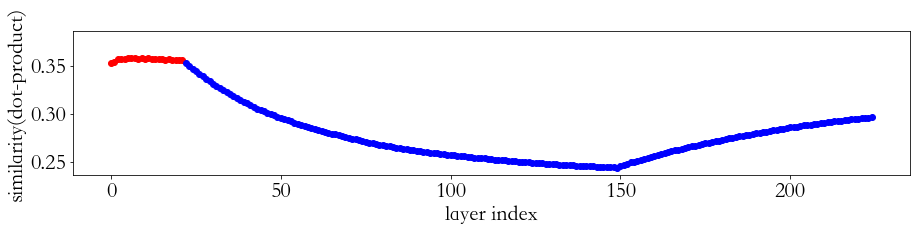

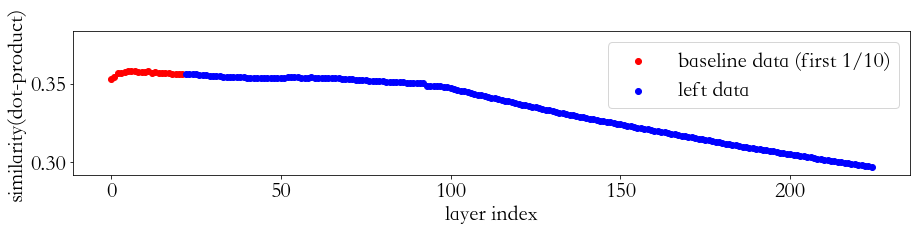

In [28]:
t11 = Dras_stat(Deal_plc('/Users/Zion/Downloads/11-PLC/'))
Draw_Corr_End_To_First(t11)
Draw_Corr(t11)

/Users/Zion/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  if __name__ == '__main__':


Read_plc() finish!!!
time cost: 22:19:19.344132
Index(['index', 'time_begin', 'time_end', '單節', '主軸負載', 'X軸機械座標', 'Y軸機械座標',
       'Z軸機械座標', '實際進給', '實際轉速', '設定進給', '設定轉速', 'file', '進給率', 'index0',
       'time_diff'],
      dtype='object')


/Users/Zion/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Seg_df() finish!!! time cost: 22:19:39.801185


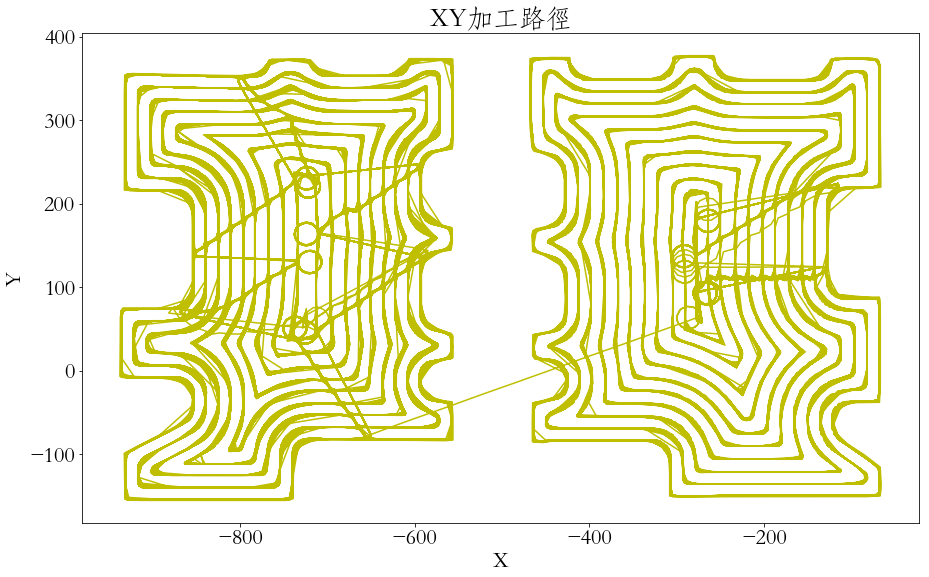

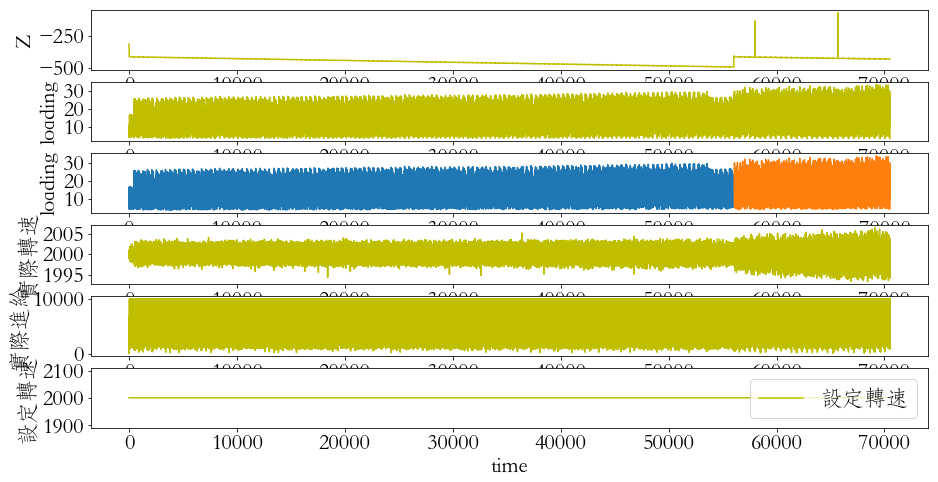

             path       layer       count        mean         std        rms2  \
count  157.000000  157.000000  157.000000  157.000000  157.000000  157.000000   
mean     1.184713   56.356688  410.993631   15.364968    4.184713   15.928663   
std      0.389307   38.788878   17.067925    1.233084    0.290041    1.262111   
min      1.000000    2.000000  399.000000   13.700000    3.700000   14.177838   
25%      1.000000   21.000000  402.000000   14.400000    4.000000   15.003996   
50%      1.000000   51.000000  403.000000   15.000000    4.100000   15.520357   
75%      1.000000   90.000000  404.000000   15.800000    4.300000   16.385379   
max      2.000000  129.000000  456.000000   18.600000    5.000000   19.277485   

              max         min         p25         p75          h0          h5  \
count  157.000000  157.000000  157.000000  157.000000  157.000000  157.000000   
mean    28.318980    4.525467   12.546320   17.912062    3.407643   32.949045   
std      2.001574    0.2423

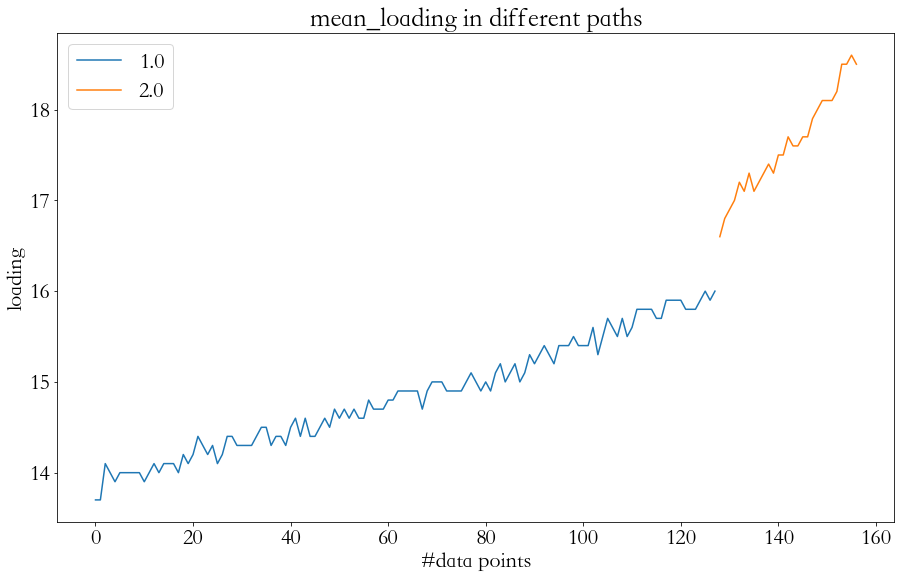

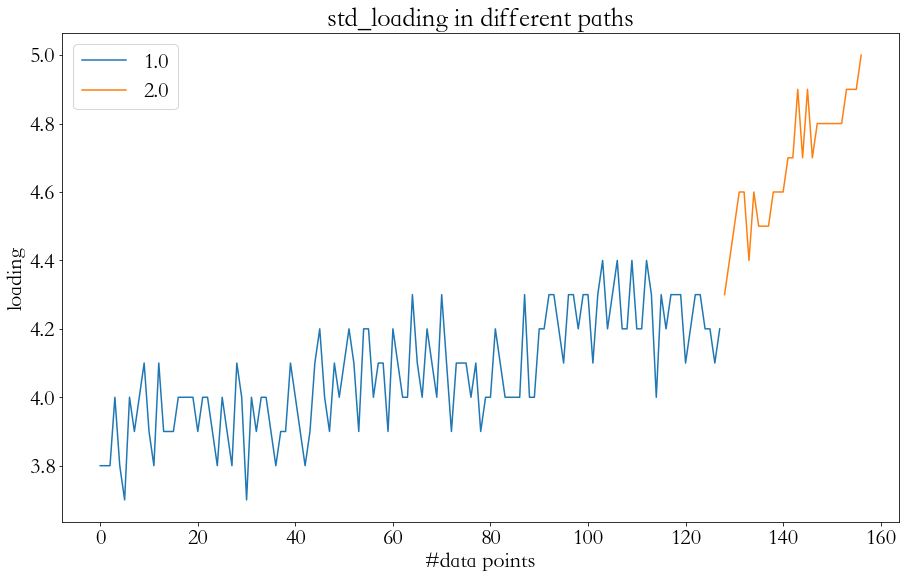

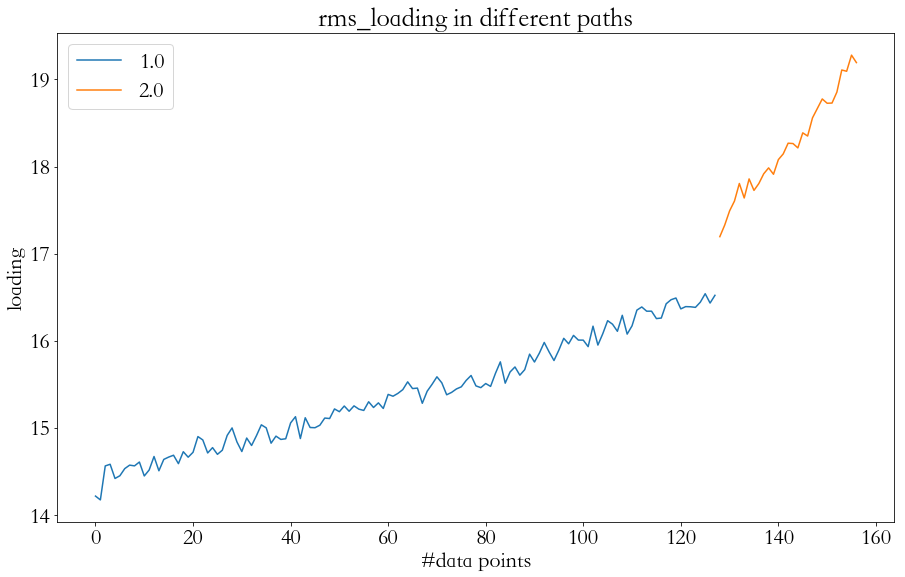

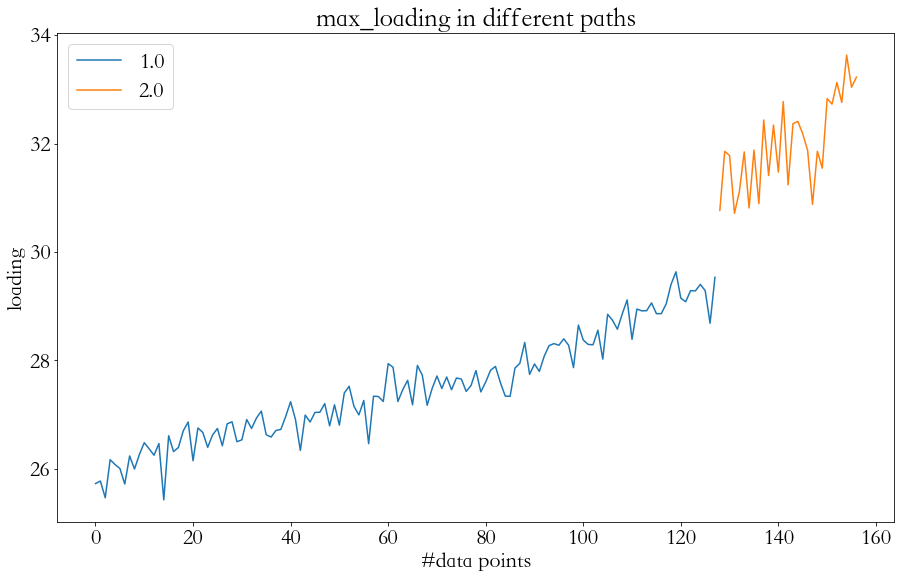

    h0   h5   h10   h15  h20  h25  h30  h35
0    7   49   180   145   19    4    0    0
1   12  102   363   277   41    8    0    0
2   17  147   570   402   59   12    0    0
3   20  193   780   526   77   15    0    0
4   22  247   973   652  102   20    0    0
5   29  292  1169   780  126   23    0    0
6   35  345  1366   904  146   27    0    0
7   40  399  1551  1033  171   31    0    0
8   45  444  1751  1166  186   35    0    0
9   49  491  1953  1296  201   39    0    0
10  51  552  2134  1427  226   43    0    0
11  58  594  2329  1562  243   47    0    0
12  65  641  2515  1700  262   52    0    0
13  70  690  2698  1840  283   57    0    0
14  78  742  2885  1966  310   62    0    0


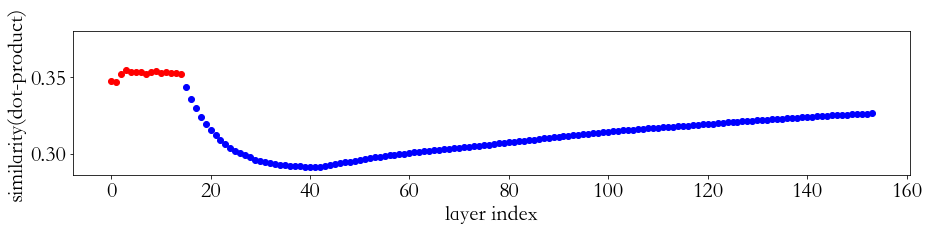

    h0   h5   h10   h15  h20  h25  h30  h35
2    7   49   180   145   19    4    0    0
3   12  102   363   277   41    8    0    0
4   17  147   570   402   59   12    0    0
5   20  193   780   526   77   15    0    0
6   22  247   973   652  102   20    0    0
7   29  292  1169   780  126   23    0    0
8   35  345  1366   904  146   27    0    0
9   40  399  1551  1033  171   31    0    0
10  45  444  1751  1166  186   35    0    0
11  49  491  1953  1296  201   39    0    0
12  51  552  2134  1427  226   43    0    0
13  58  594  2329  1562  243   47    0    0
14  65  641  2515  1700  262   52    0    0
15  70  690  2698  1840  283   57    0    0
16  78  742  2885  1966  310   62    0    0


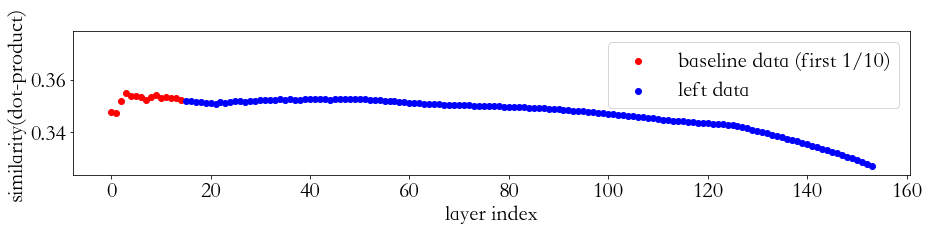

In [32]:
t10 = Dras_stat(Deal_plc('/Users/Zion/Downloads/10-PLC/'))
Draw_Corr_End_To_First(t10)
Draw_Corr(t10)

Read_plc() finish!!!
time cost: 22:15:27.920586
Index(['index', 'time_begin', 'time_end', '單節', '主軸負載', 'X軸機械座標', 'Y軸機械座標',
       'Z軸機械座標', '實際進給', '實際轉速', '設定進給', '設定轉速', 'file', '進給率', 'index0',
       'time_diff'],
      dtype='object')
Seg_df() finish!!! time cost: 22:15:34.581461


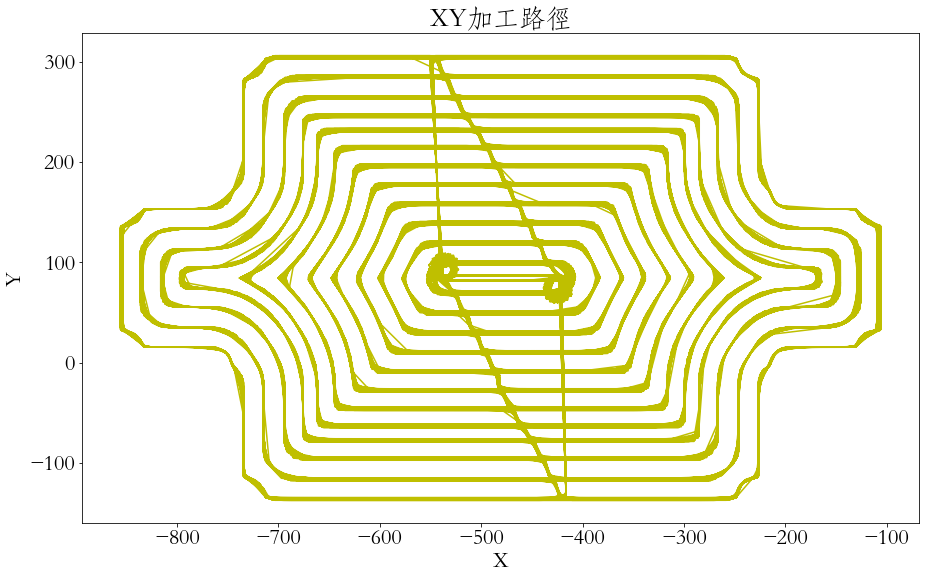

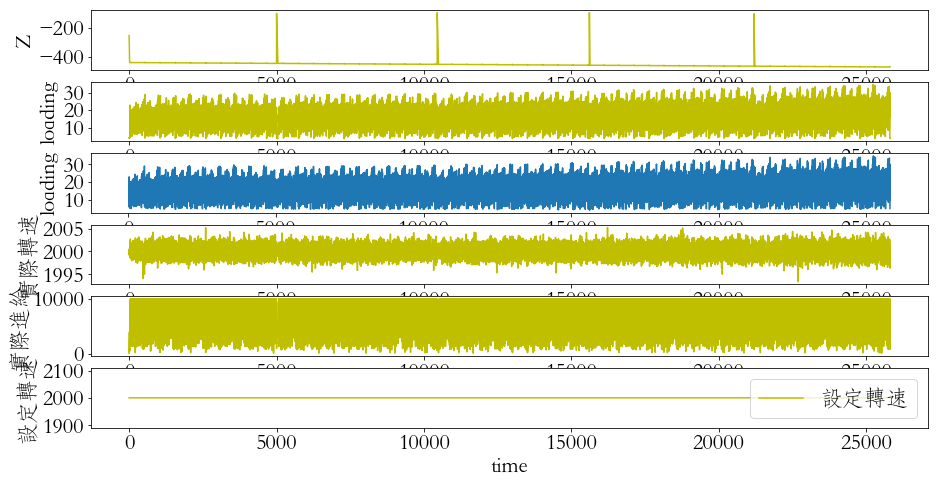

       path       layer       count       mean        std       rms2  \
count  44.0   44.000000   44.000000  44.000000  44.000000  44.000000   
mean    1.0   77.840909  502.113636  18.863636   5.095455  19.536550   
std     0.0   47.714238    4.047485   1.024829   0.408032   1.095399   
min     1.0    2.000000  496.000000  17.200000   4.500000  17.864441   
25%     1.0   33.750000  499.000000  18.000000   4.800000  18.613387   
50%     1.0  108.500000  503.000000  18.700000   5.000000  19.340210   
75%     1.0  119.250000  504.000000  19.700000   5.425000  20.448814   
max     1.0  130.000000  518.000000  20.800000   5.900000  21.638572   

             max        min        p25        p75         h0         h5  \
count  44.000000  44.000000  44.000000  44.000000  44.000000  44.000000   
mean   30.780622   4.575765  15.518073  22.643659   3.613636  23.068182   
std     1.791218   0.208568   0.837528   1.362604   1.645514   4.421921   
min    28.489029   4.040651  14.024018  20.798364  

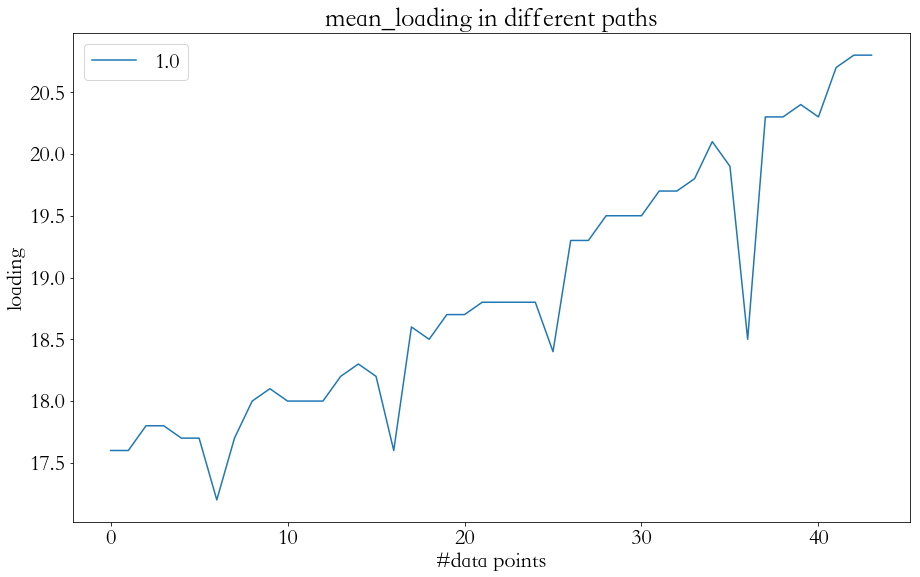

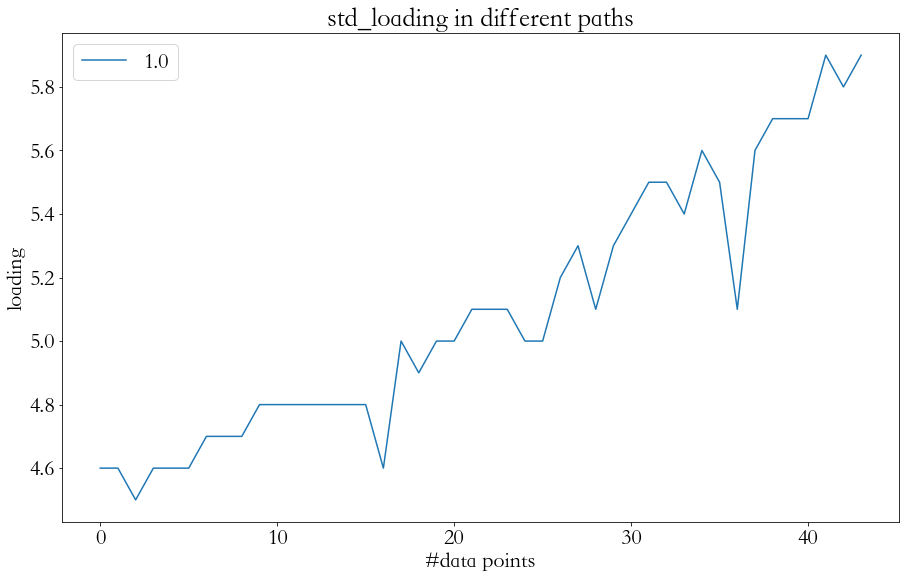

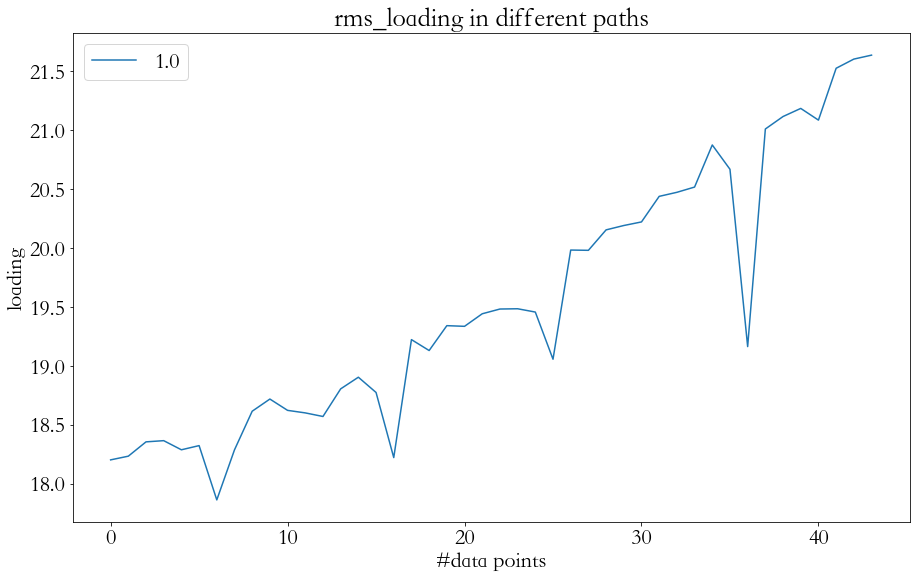

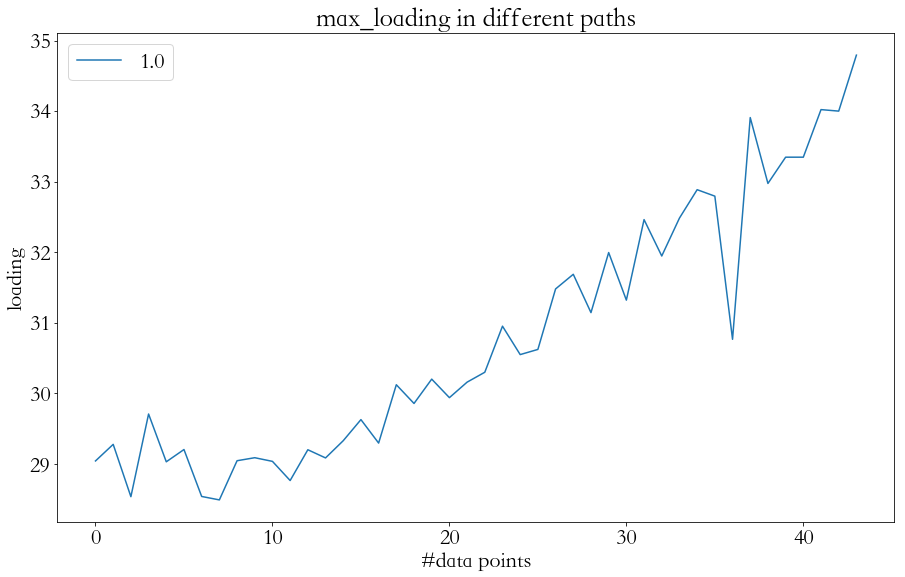

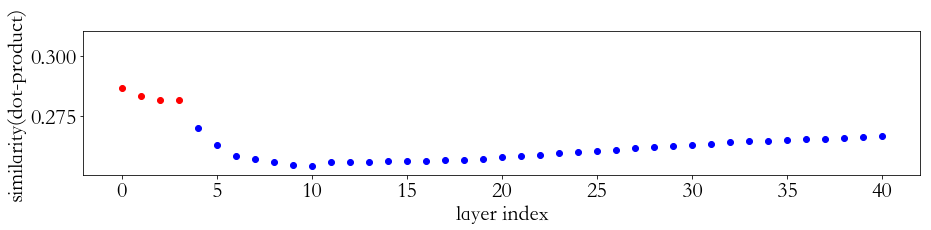

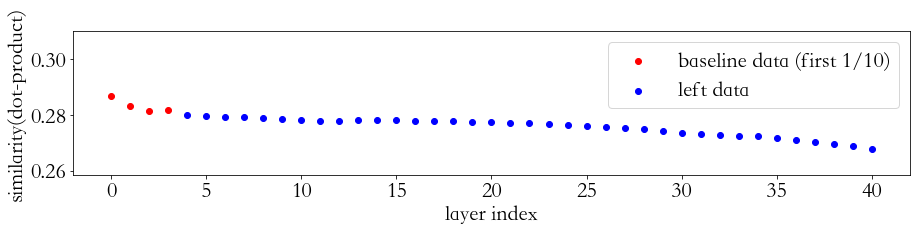

In [30]:
t9 = Dras_stat(Deal_plc('/Users/Zion/Downloads/9-PLC/'))
Draw_Corr_End_To_First(t9)
Draw_Corr(t9)

array([4, 3, 4, ..., 3, 4, 4])

In [77]:
def Cal_no_layer(z15):
    h0 = []
    h5 = []
    h10 = []
    h15 = []
    h20 = []
    h25 = []
    h30 = []
    h35 = []
    N=500
    for i in np.arange(0,len(z15)-N, 500):
        df = z15.iloc[i:i+N]
        his = np.histogram(df['主軸負載'].values, bins=range(0,45,5))[0]
        #his = np.histogram(df['實際進給'].values, bins=range(0,10000,1111))[0]
        
        
        h0.append(his[0])
        h5.append(his[1])
        h10.append(his[2])
        h15.append(his[3])
        h20.append(his[4])
        h25.append(his[5])
        h30.append(his[6])
        h35.append(his[7])

        #print(his)
    stat_df_15 = pd.DataFrame({'h0':h0,'h5':h5,'h10':h10,'h15':h15,'h20':h20,'h25':h25,'h30':h30,'h35':h35})
    print(len(stat_df_15))
    #print(stat_df_15)
    Draw_Corr(stat_df_15)
    Draw_Corr_End_To_First(stat_df_15)

#15
126


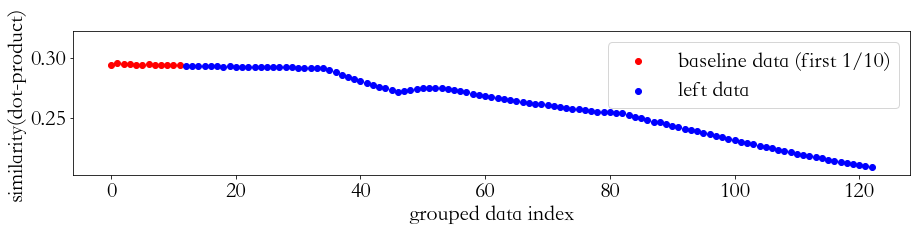

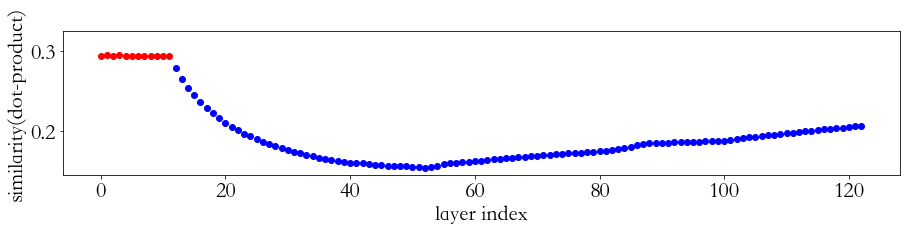

#14
115


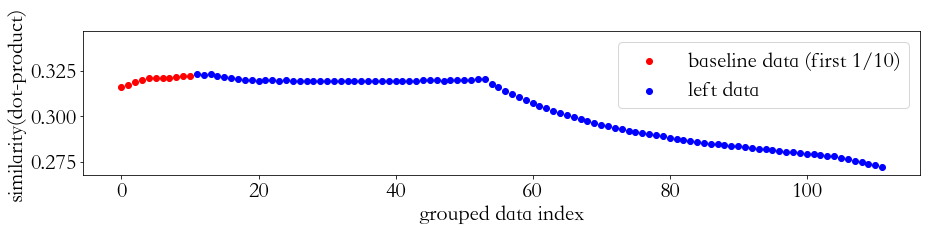

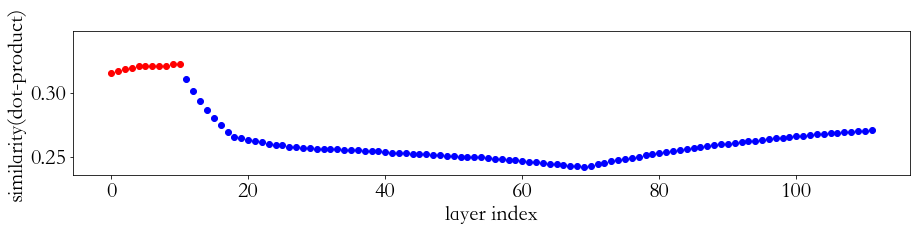

#13
151


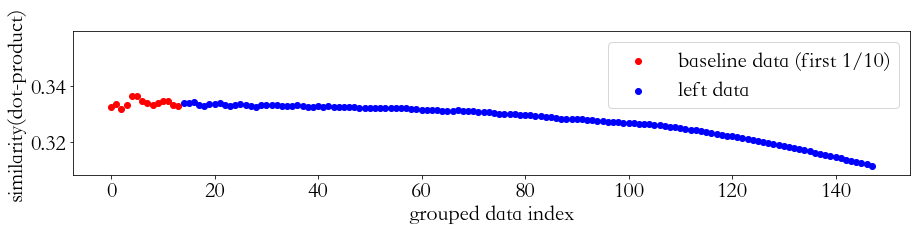

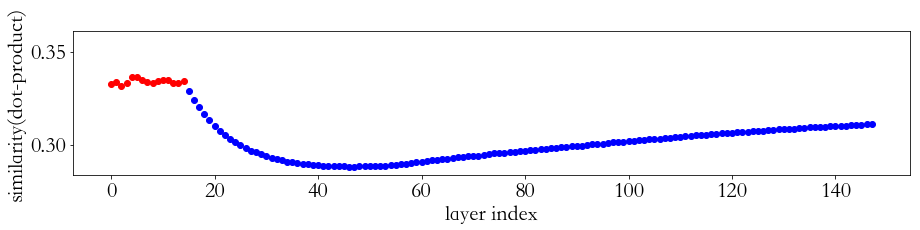

#12
111


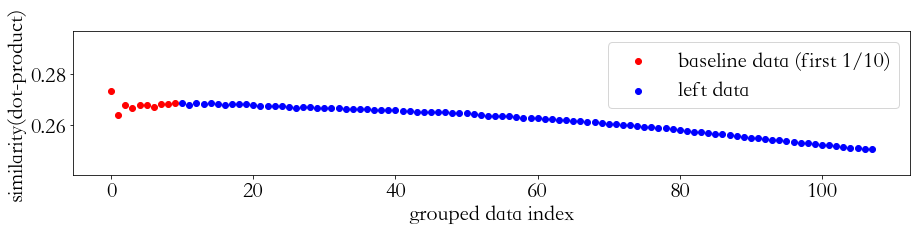

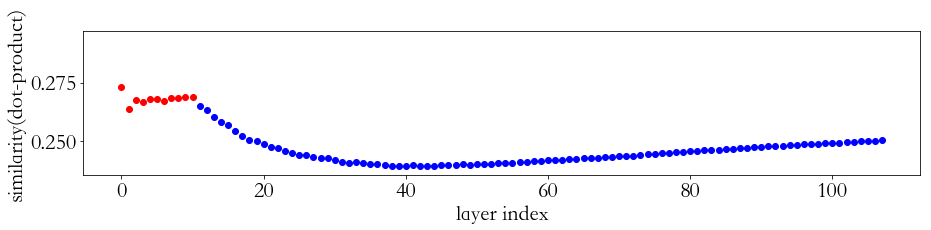

#11
152


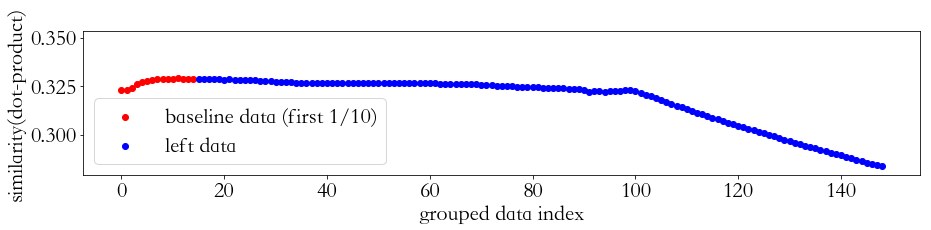

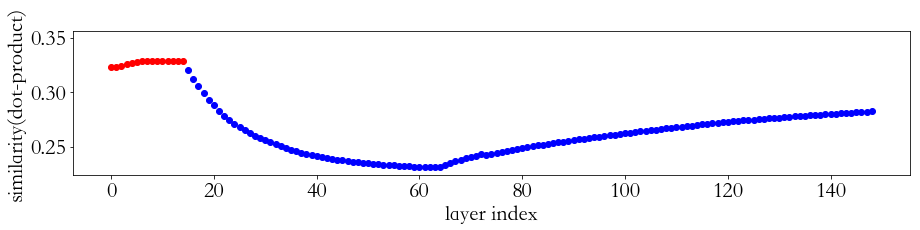

#10
141


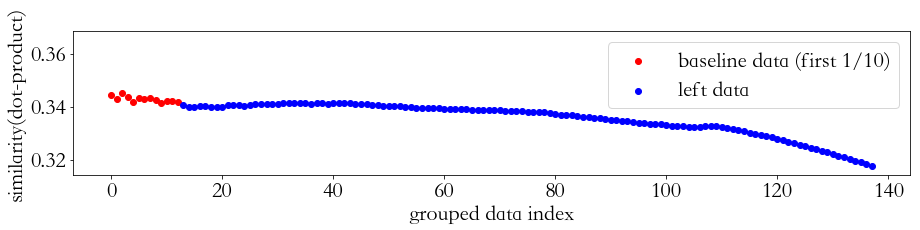

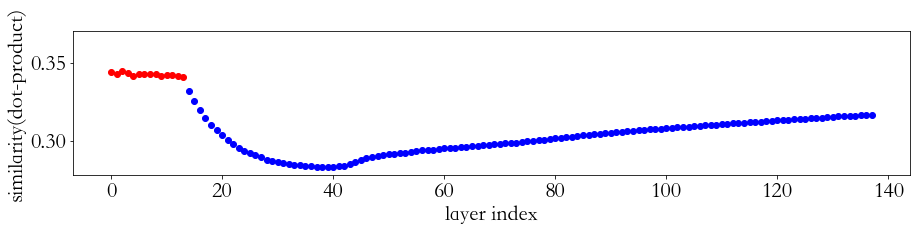

#9
51


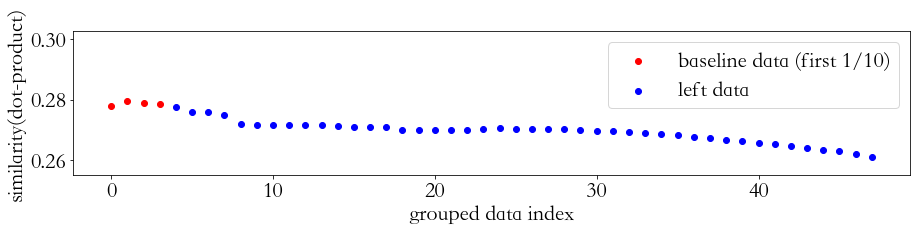

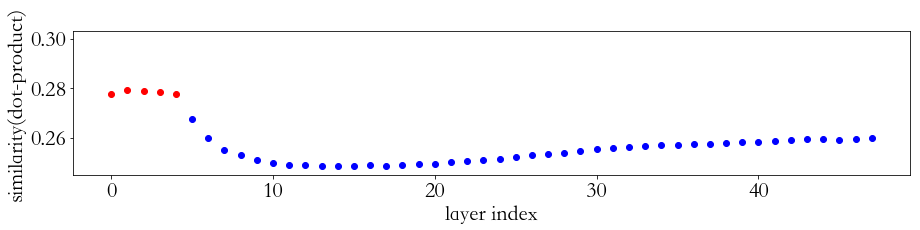

In [78]:
print('#15')
Cal_no_layer(z15)
print('#14')

Cal_no_layer(z14)
print('#13')

Cal_no_layer(z13)
print('#12')

Cal_no_layer(z12)
print('#11')

Cal_no_layer(z11)
print('#10')

Cal_no_layer(z10)
print('#9')

Cal_no_layer(z9)

In [88]:
load_all = z15['主軸負載'].values.astype(int)

In [152]:
load_all = load_all/50

In [154]:
np.max(load_all)

0.96

In [163]:
base_load = load_all[:6000]
rest_load = load_all[6000:57400]
print(len(base_load), len(rest_load))

6000 51400


In [164]:
base_load = base_load.reshape([-1,100,1])
rest_load = rest_load.reshape([-1,100,1])

In [165]:
rest_load

array([[[0.12],
        [0.22],
        [0.34],
        ...,
        [0.12],
        [0.08],
        [0.06]],

       [[0.06],
        [0.06],
        [0.08],
        ...,
        [0.08],
        [0.12],
        [0.26]],

       [[0.3 ],
        [0.16],
        [0.18],
        ...,
        [0.06],
        [0.06],
        [0.14]],

       ...,

       [[0.24],
        [0.26],
        [0.46],
        ...,
        [0.2 ],
        [0.44],
        [0.32]],

       [[0.34],
        [0.36],
        [0.32],
        ...,
        [0.38],
        [0.32],
        [0.44]],

       [[0.24],
        [0.34],
        [0.3 ],
        ...,
        [0.38],
        [0.56],
        [0.38]]])

In [162]:
    import random
    import numpy as np
    import tensorflow as tf
    from tensorflow.python.keras.layers import Input, LSTM, RepeatVector, Convolution1D, MaxPooling1D, UpSampling1D
    from tensorflow.python.keras.models import Model
    np.random.seed(1337)
    timesteps = 100
    input_dim = 1
    latent_dim = 30
    
    def make_lstm():
        inputs = Input(shape=(timesteps, input_dim))
        encoded = LSTM(latent_dim)(inputs)
        decoded = RepeatVector(timesteps)(encoded)
        decoded = LSTM(input_dim, return_sequences=True)(decoded)
        sequence_autoencoder = Model(inputs, decoded)
    
        sequence_autoencoder.compile(loss='mean_squared_error', optimizer='adam')
        return sequence_autoencoder
    
    
    #sequence_autoencoder, encoder = make_lstm()
    sequence_autoencoder = make_lstm()
    
    print(sequence_autoencoder.summary())
    
    x_train = base_load
    sequence_autoencoder.fit(x_train, x_train, epochs=10, steps_per_epoch=10, verbose=2)
    
    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 100, 1)            0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 30)                3840      
_________________________________________________________________
repeat_vector_7 (RepeatVecto (None, 100, 30)           0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 100, 1)            128       
Total params: 3,968
Trainable params: 3,968
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
 - 4s - loss: 0.0170
Epoch 2/10
 - 1s - loss: 0.0092
Epoch 3/10
 - 1s - loss: 0.0089
Epoch 4/10
 - 2s - loss: 0.0086
Epoch 5/10
 - 2s - loss: 0.0085
Epoch 6/10
 - 2s - loss: 0.0085
Epoch 7/10
 - 1s - loss: 0.0084
Epoch 8/10
 - 1s - loss: 0.0084
Epoch 9/10


In [176]:
len(rest_load), len(base_load)

(514, 60)

In [177]:
errs = []
for i in range(len(base_load)):
        print(i,'---------')
        predicted = sequence_autoencoder.predict(base_load[i:i+1])
        evaluated = sequence_autoencoder.evaluate(base_load[i:i+1],base_load[i:i+1])
        expected = base_load[0:1]
        errs.append(evaluated)
        print(evaluated)

0 ---------
1/1 [==============================] - 0s 28ms/step
0.005138246342539787
1 ---------
1/1 [==============================] - 0s 29ms/step
0.007893848232924938
2 ---------
1/1 [==============================] - 0s 30ms/step
0.006222590804100037
3 ---------
1/1 [==============================] - 0s 30ms/step
0.014922239817678928
4 ---------
1/1 [==============================] - 0s 38ms/step
0.0061003644950687885
5 ---------
1/1 [==============================] - 0s 28ms/step
0.008665477856993675
6 ---------
1/1 [==============================] - 0s 28ms/step
0.006846525240689516
7 ---------
1/1 [==============================] - 0s 29ms/step
0.011306223459541798
8 ---------
1/1 [==============================] - 0s 31ms/step
0.005345816724002361
9 ---------
1/1 [==============================] - 0s 29ms/step
0.008852413855493069
10 ---------
1/1 [==============================] - 0s 30ms/step
0.0066526723094284534
11 ---------
1/1 [==============================] - 0s 34ms/st

In [178]:
#errs = []
for i in range(len(rest_load)):
        print(i,'---------')
        predicted = sequence_autoencoder.predict(rest_load[i:i+1])
        evaluated = sequence_autoencoder.evaluate(rest_load[i:i+1],rest_load[i:i+1])
        expected = rest_load[0:1]
        errs.append(evaluated)
        print(evaluated)
        #for x,y in zip(expected[0], predicted[0]):
        #    print(x,y,evaluated)

0 ---------
1/1 [==============================] - 0s 25ms/step
0.006017229054123163
1 ---------
1/1 [==============================] - 0s 29ms/step
0.00810100045055151
2 ---------
1/1 [==============================] - 0s 32ms/step
0.01039485726505518
3 ---------
1/1 [==============================] - 0s 34ms/step
0.00949167087674141
4 ---------
1/1 [==============================] - 0s 54ms/step
0.005846517626196146
5 ---------
1/1 [==============================] - 0s 40ms/step
0.007122695446014404
6 ---------
1/1 [==============================] - 0s 36ms/step
0.015466684475541115
7 ---------
1/1 [==============================] - 0s 38ms/step
0.009293105453252792
8 ---------
1/1 [==============================] - 0s 29ms/step
0.007244508247822523
9 ---------
1/1 [==============================] - 0s 35ms/step
0.006098642945289612
10 ---------
1/1 [==============================] - 0s 32ms/step
0.012904606759548187
11 ---------
1/1 [==============================] - 0s 21ms/step
0.

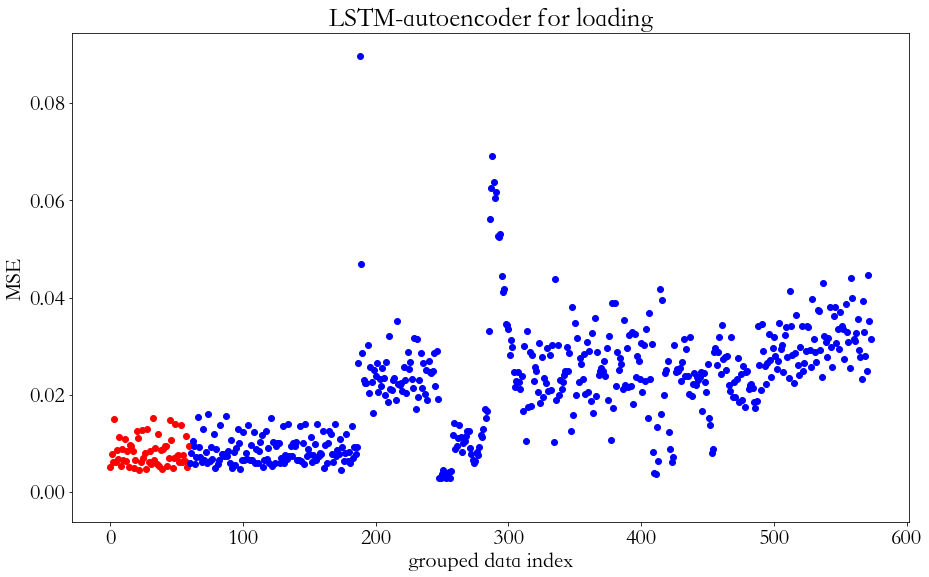

In [186]:
plt.figure(figsize=(15,9))
plt.scatter(range(len(base_load)),errs[:60],c='r')
plt.scatter(range(len(base_load), len(base_load)+len(rest_load)),errs[60:],c='b')
plt.ylabel('MSE')
plt.xlabel('grouped data index')
plt.title('LSTM-autoencoder for loading')
plt.show()    


In [182]:
sequence_autoencoder.metrics_names

['loss']